In [1]:
from pathlib import Path 
import sys 
sys.path.append(str(Path.cwd()))

In [2]:
from utils import predictors, data_loading as dl
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MAX_PLOT_HORIZON = 1000
MAX_PLOT_TRAIN = 100

EVALUATION_RESULTS = {}

In [4]:
def plot_predictions(y_train, y_test, y_hat_test):
    xrange_train = np.arange(y_train.shape[0])
    xrange_test = np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0])
    sns.lineplot(y=y_train, x=xrange_train, label="train")
    sns.lineplot(y=y_test, x=xrange_test, label="test")
    if y_hat_test is not None:
        sns.lineplot(y=y_hat_test, x=xrange_test, label="prediction")
    # plot vertical dotted line
    plt.axvline(x=y_train.shape[0], linestyle="--", color="black")
    plt.legend()

In [5]:
def calculate_rmse(y_test, y_hat_test):
    se = (y_hat_test - y_test) ** 2
    predicted_days = np.arange(1, se.shape[0]+1)
    rmse = np.sqrt(np.cumsum(se) / predicted_days)

    for h in [10, 50, 100, 200, 300, 1000, y_test.shape[0]]:
        if h > y_test.shape[0]:
            continue
        print(f"{h} steps horizon - rmse = {round(rmse[h-1], 4)}")

    sns.lineplot(y=rmse, x=predicted_days, label="rmse")
    return rmse

# Datasets

In [6]:
sunspots = dl.DataLoader(dl.DATASET.SUNSPOTS, use_test=True)
electricity = dl.DataLoader(dl.DATASET.ELECTRICITY, use_test=True)
mackey_glass = dl.DataLoader(dl.DATASET.MACKEY_GLASS, use_test=True)
temperature = dl.DataLoader(dl.DATASET.TEMPERATURE, use_test=True)

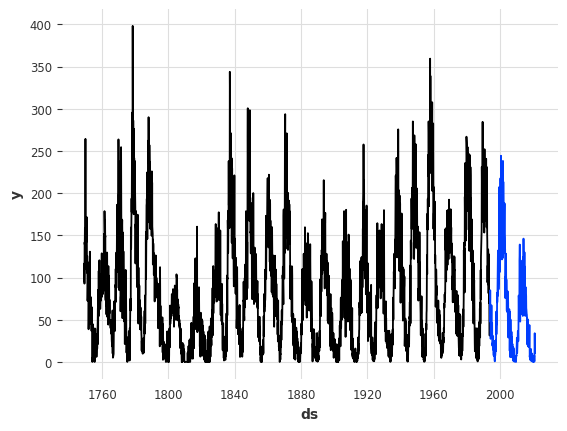

In [7]:
sns.lineplot(data=sunspots.train_df, x="ds", y="y")
sns.lineplot(data=sunspots.val_df, x="ds", y="y")
plt.show()

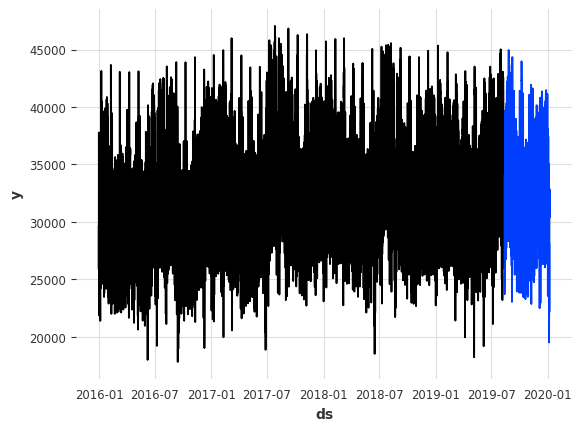

In [8]:
sns.lineplot(data=electricity.train_df, x="ds", y="y")
sns.lineplot(data=electricity.val_df, x="ds", y="y")
plt.show()

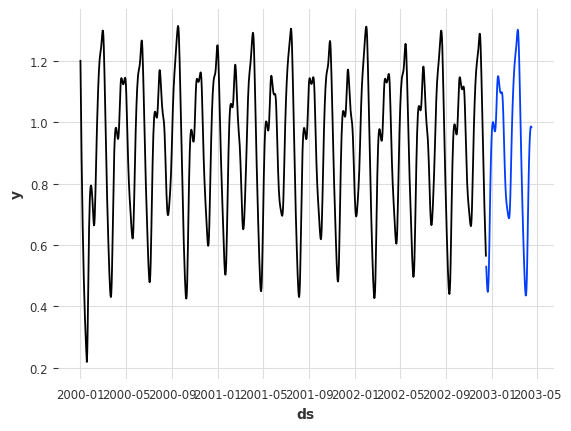

In [9]:
sns.lineplot(data=mackey_glass.train_df, x="ds", y="y")
sns.lineplot(data=mackey_glass.val_df, x="ds", y="y")
plt.show()

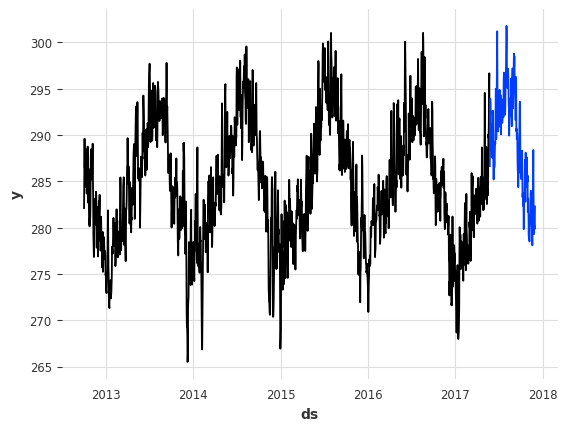

In [10]:
sns.lineplot(data=temperature.train_df, x="ds", y="y")
sns.lineplot(data=temperature.val_df, x="ds", y="y")
plt.show()

# Forecasting with Prophet

## Train model

In [11]:
model_name = "prophet"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
prophet_params = {
    dl.DATASET.SUNSPOTS: {
        "seasonality_mode": "multiplicative",
        "daily_seasonality": False,
        "weekly_seasonality": False,
        "custom_seasonality": int(11 * 365),
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 1.0,
    },
    dl.DATASET.ELECTRICITY: {
        "changepoint_prior_scale": 0.01,
        "seasonality_prior_scale": 0.01,
        "seasonality_mode": "additive",
    },
    dl.DATASET.MACKEY_GLASS: {
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 1.0,
        "seasonality_mode": "multiplicative",
        "custom_seasonality": 100,
    },
    dl.DATASET.TEMPERATURE: {
        "changepoint_prior_scale": 0.1,
        "seasonality_prior_scale": 1.0,
        "seasonality_mode": "additive",
    },
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = prophet_params[dataset.name]
    model = predictors.ProphetPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)


17:55:54 - cmdstanpy - INFO - Chain [1] start processing
17:55:56 - cmdstanpy - INFO - Chain [1] done processing


DATASET.ELECTRICITY
(31707, 2)


17:56:00 - cmdstanpy - INFO - Chain [1] start processing
17:56:13 - cmdstanpy - INFO - Chain [1] done processing


DATASET.MACKEY_GLASS
(1080, 2)


17:56:14 - cmdstanpy - INFO - Chain [1] start processing
17:56:16 - cmdstanpy - INFO - Chain [1] done processing


DATASET.TEMPERATURE
(1697, 2)


17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:17 - cmdstanpy - INFO - Chain [1] done processing


## Evaluate model

DATASET.SUNSPOTS


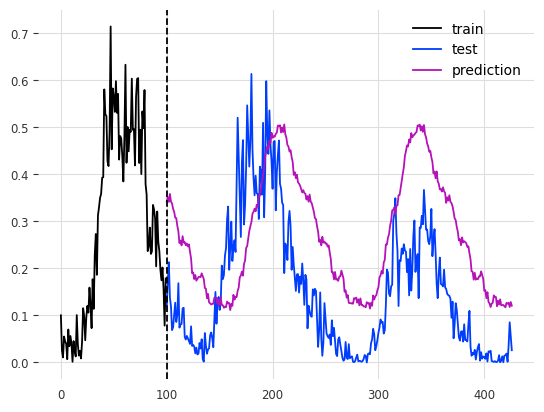

10 steps horizon - rmse = 0.2151
50 steps horizon - rmse = 0.1604
100 steps horizon - rmse = 0.1541
200 steps horizon - rmse = 0.1591
300 steps horizon - rmse = 0.1698
327 steps horizon - rmse = 0.1661


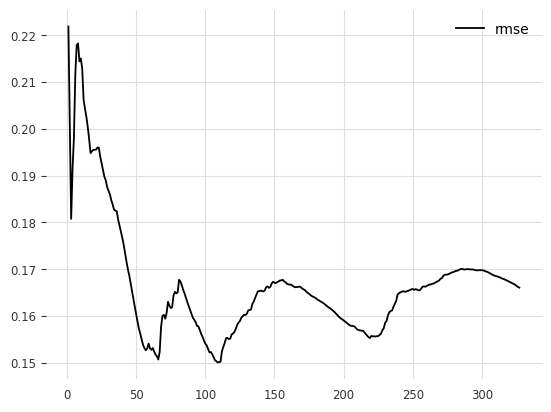


******************************

DATASET.ELECTRICITY


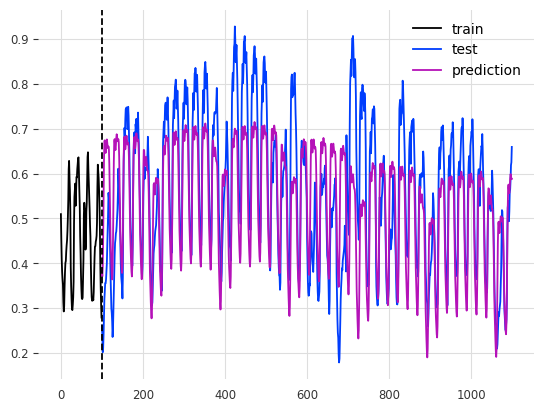

10 steps horizon - rmse = 0.2738
50 steps horizon - rmse = 0.1923
100 steps horizon - rmse = 0.1397
200 steps horizon - rmse = 0.11
300 steps horizon - rmse = 0.1034
1000 steps horizon - rmse = 0.1144
3524 steps horizon - rmse = 0.1048


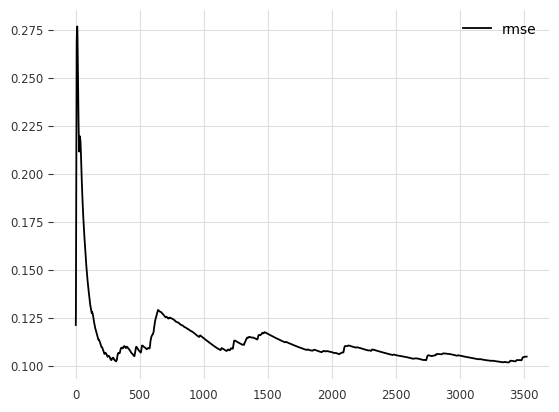


******************************

DATASET.MACKEY_GLASS


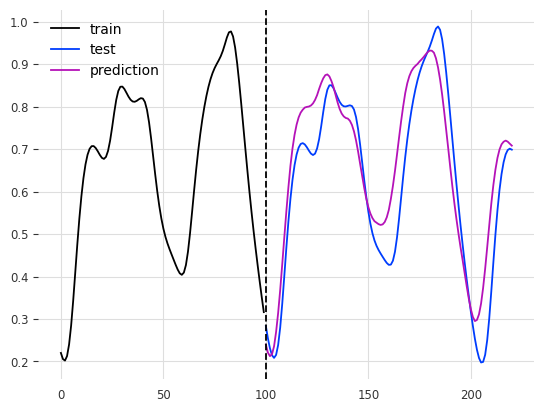

10 steps horizon - rmse = 0.0613
50 steps horizon - rmse = 0.0678
100 steps horizon - rmse = 0.086
121 steps horizon - rmse = 0.0943


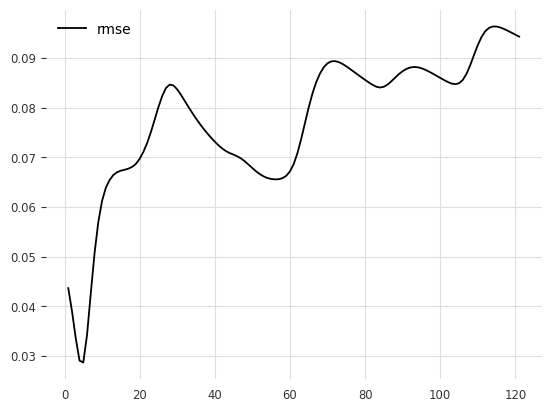


******************************

DATASET.TEMPERATURE


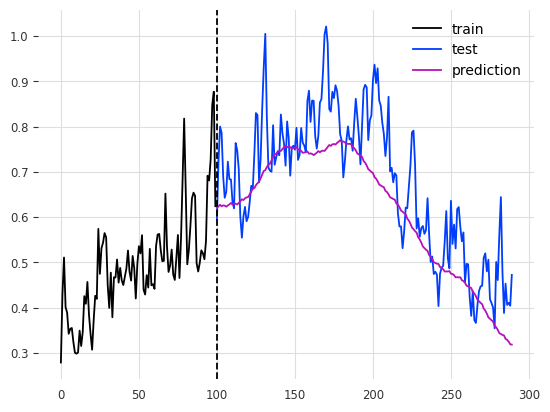

10 steps horizon - rmse = 0.0935
50 steps horizon - rmse = 0.089
100 steps horizon - rmse = 0.0972
190 steps horizon - rmse = 0.1026


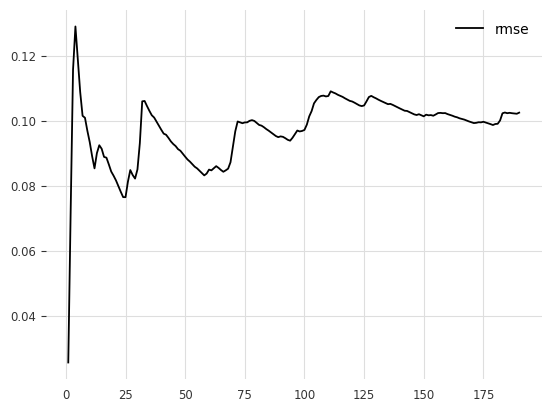


******************************



In [12]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(dataset.df_val[["ds"]])

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with SARIMA

## Train model

In [13]:
model_name = "sarima"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
sarima_params = {
    dl.DATASET.SUNSPOTS: {
        "order": (5, 0, 5),
        # "seasonal_order": (2, 0, 2, 130),
    },
    dl.DATASET.ELECTRICITY: {
        "order": (3, 0, 5),
        # "seasonal_order": (1, 0, 2, 24),
    },
    dl.DATASET.MACKEY_GLASS: {
        "order": (5, 0, 5),
        # "seasonal_order": (2, 0, 2, 50),
    },
    dl.DATASET.TEMPERATURE: {
        "order": (5, 0, 5),
        # "seasonal_order": (2, 0, 2, 365),
    },
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    X_train = df_train.y.values
    print(X_train.shape)
    params = sarima_params[dataset.name]
    model = predictors.SARIMAPredictor(**params)
    model.fit(X_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938,)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


DATASET.ELECTRICITY
(31707,)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


DATASET.MACKEY_GLASS
(1080,)
DATASET.TEMPERATURE
(1697,)


/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Evaluate model

DATASET.SUNSPOTS


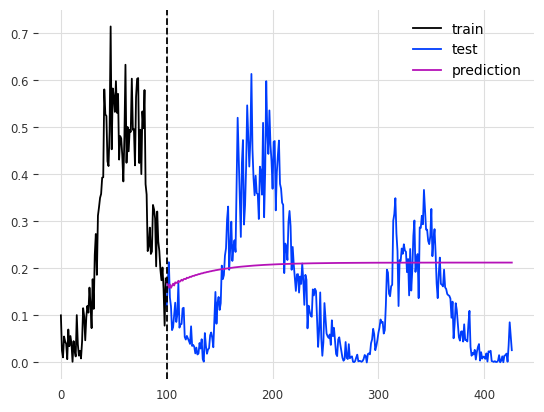

10 steps horizon - rmse = 0.0619
50 steps horizon - rmse = 0.1218
100 steps horizon - rmse = 0.1627
200 steps horizon - rmse = 0.1593
300 steps horizon - rmse = 0.1448
327 steps horizon - rmse = 0.1499


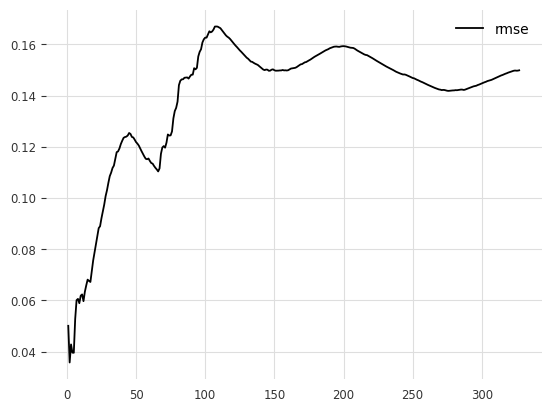


******************************

DATASET.ELECTRICITY


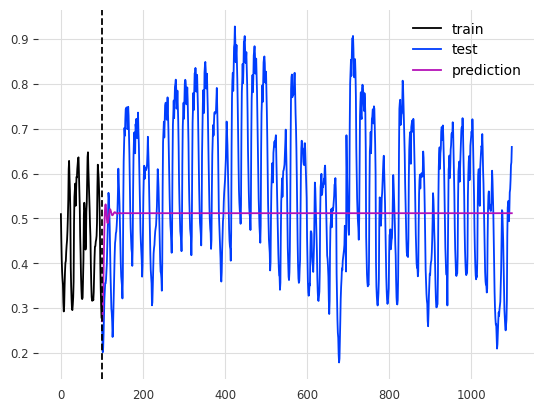

10 steps horizon - rmse = 0.1343
50 steps horizon - rmse = 0.1277
100 steps horizon - rmse = 0.1415
200 steps horizon - rmse = 0.147
300 steps horizon - rmse = 0.1652
1000 steps horizon - rmse = 0.1679
3524 steps horizon - rmse = 0.1586


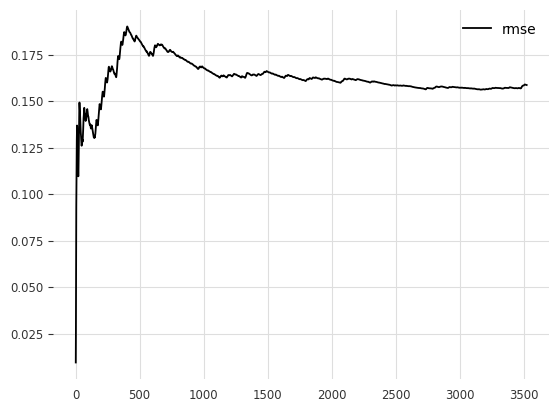


******************************

DATASET.MACKEY_GLASS


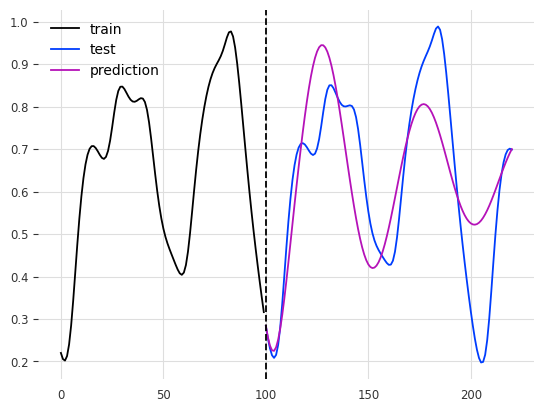

10 steps horizon - rmse = 0.0212
50 steps horizon - rmse = 0.129
100 steps horizon - rmse = 0.125
121 steps horizon - rmse = 0.144


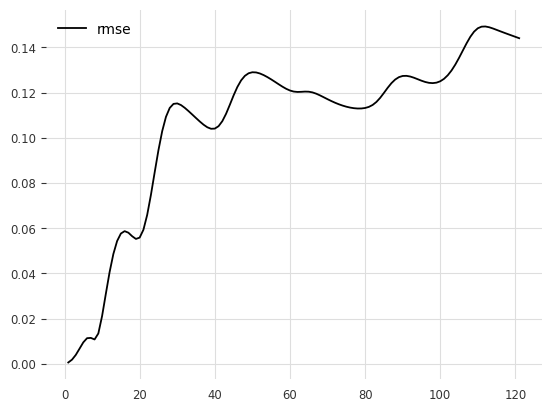


******************************

DATASET.TEMPERATURE


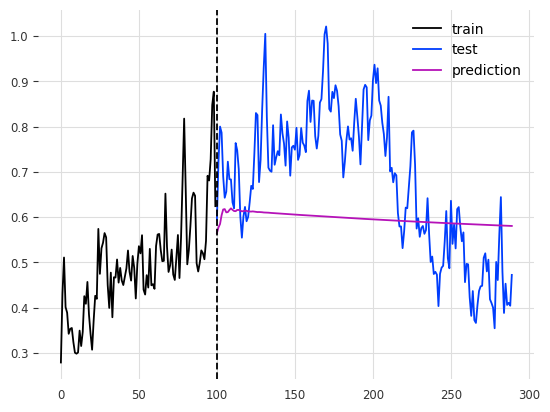

10 steps horizon - rmse = 0.1144
50 steps horizon - rmse = 0.1439
100 steps horizon - rmse = 0.1924
190 steps horizon - rmse = 0.1694


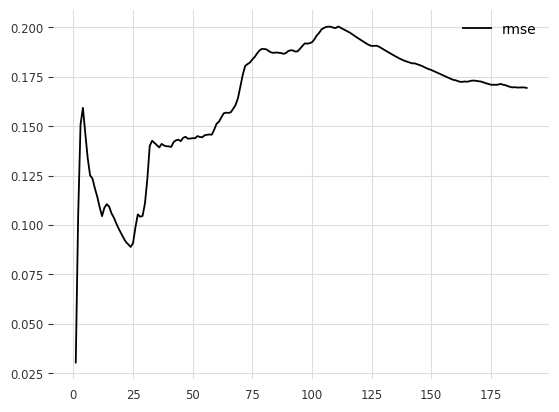


******************************



In [14]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val.shape[0])
    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with TFT (one step ahead)

## Evaluate pretrained models

DATASET.SUNSPOTS
/home/glegeza/Programming/semestr1/time-series-forecasting/models/tft/sunspots01:52:41


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [01:09<00:00, 70.00s/it]


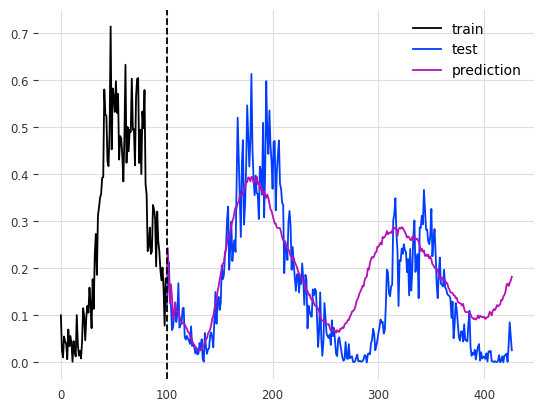

10 steps horizon - rmse = 0.0426
50 steps horizon - rmse = 0.0304
100 steps horizon - rmse = 0.0679
200 steps horizon - rmse = 0.0832
300 steps horizon - rmse = 0.0825
327 steps horizon - rmse = 0.0856


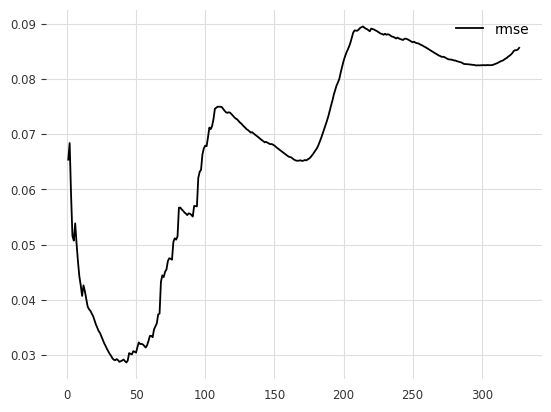


******************************

DATASET.ELECTRICITY
/home/glegeza/Programming/semestr1/time-series-forecasting/models/tft/electricity08:06:31


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [12:13<00:00, 733.20s/it]


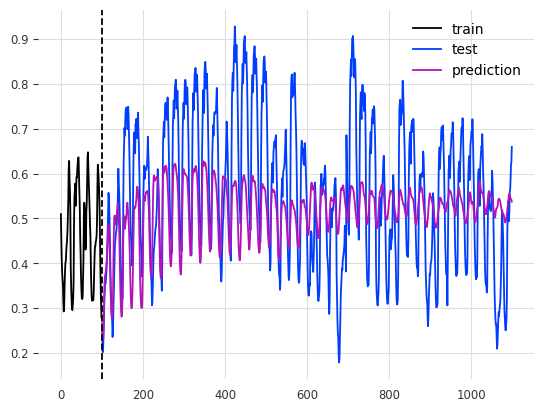

10 steps horizon - rmse = 0.0242
50 steps horizon - rmse = 0.0574
100 steps horizon - rmse = 0.1198
200 steps horizon - rmse = 0.1141
300 steps horizon - rmse = 0.1241
1000 steps horizon - rmse = 0.143
3524 steps horizon - rmse = 0.1542


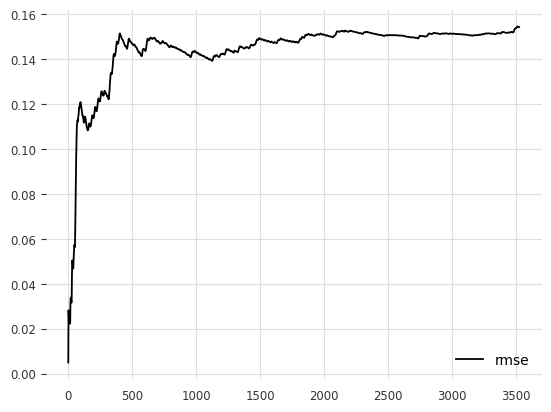


******************************

DATASET.MACKEY_GLASS
/home/glegeza/Programming/semestr1/time-series-forecasting/models/tft/mackey_glass08:16:47


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:26<00:00, 26.84s/it]


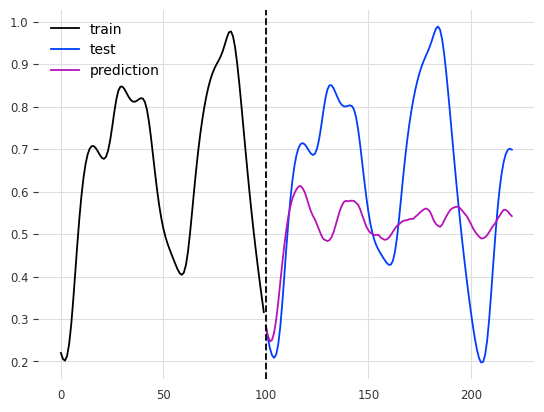

10 steps horizon - rmse = 0.068
50 steps horizon - rmse = 0.1881
100 steps horizon - rmse = 0.2176
121 steps horizon - rmse = 0.214


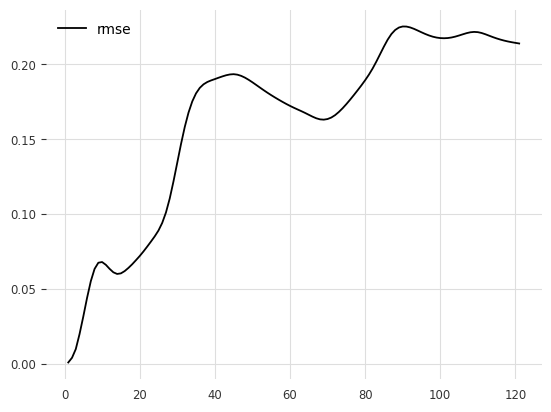


******************************

DATASET.TEMPERATURE
/home/glegeza/Programming/semestr1/time-series-forecasting/models/tft/temperature08:33:50


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:39<00:00, 39.99s/it]


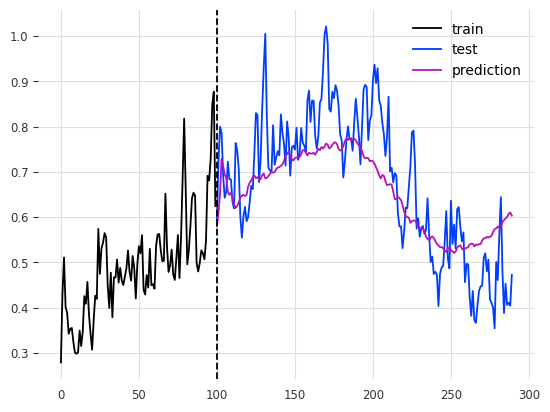

10 steps horizon - rmse = 0.0699
50 steps horizon - rmse = 0.0891
100 steps horizon - rmse = 0.0948
190 steps horizon - rmse = 0.1015


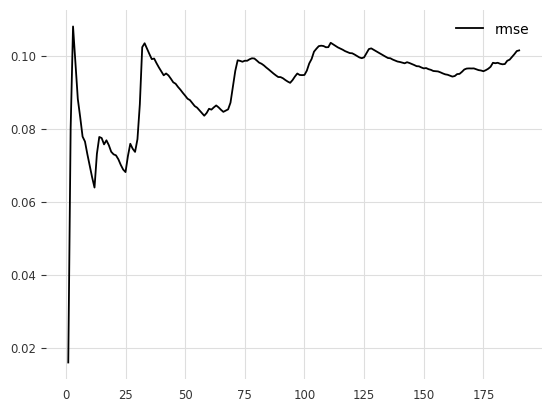


******************************



In [15]:
from collections import defaultdict

model_name = "tft-autoregresive"
WEIGHTS_DIR = Path().cwd().parent / "models/tft"

EVALUATION_RESULTS[model_name] = defaultdict(dict)

datasets = [sunspots, electricity, mackey_glass, temperature]

for dataset in datasets:
    print(dataset.name)
    model_fname, model_covariates = predictors.get_tft_weights_covariates(dataset.name, multihorizon=False)
    model_path = str(WEIGHTS_DIR / model_fname)
    print(model_path)

    y_pred = predictors.get_tft_predictions(model_path, dataset, model_covariates)
    y_val = dataset.y_val
    y_train = dataset.y_train

    plot_predictions(y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with XGBoost - autoregressive

## Train model

In [16]:
model_name = "xgboost - ar"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
xgboost_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": True,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": None,
        "mode": 1
    }
}

for dataset in datasets:
    print(dataset.name)
    X_train = dataset.X_train
    y_train = dataset.y_train
    print(dataset.df_train.shape)
    params = xgboost_params[dataset.name]
    model = predictors.XGBoostPredictor(**params)
    model.fit(X=X_train, y=y_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)
DATASET.ELECTRICITY
(31706, 2)
DATASET.MACKEY_GLASS
(1080, 2)
DATASET.TEMPERATURE
(1697, 2)


## Evaluate model

DATASET.SUNSPOTS


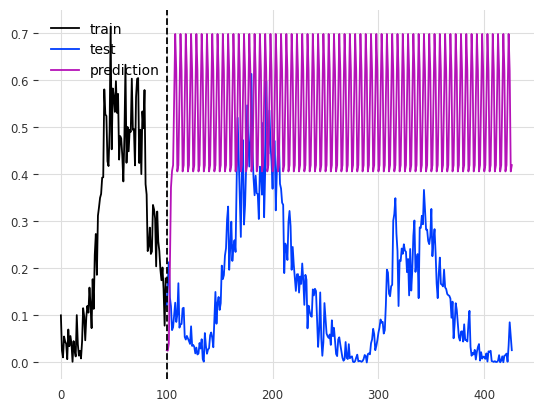

10 steps horizon - rmse = 0.3434
50 steps horizon - rmse = 0.4689
100 steps horizon - rmse = 0.3732
200 steps horizon - rmse = 0.4156
300 steps horizon - rmse = 0.4132
327 steps horizon - rmse = 0.4238


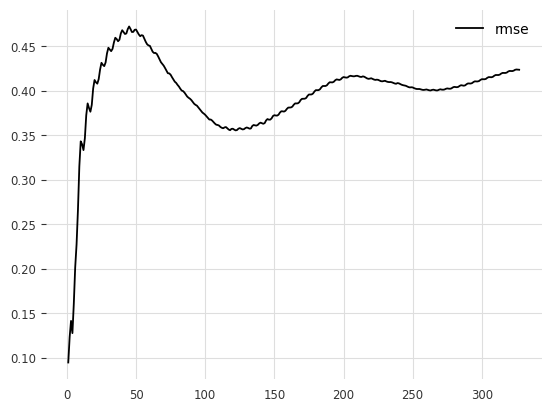


******************************

DATASET.ELECTRICITY


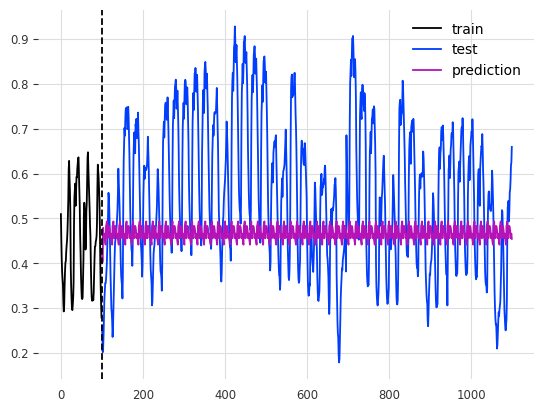

10 steps horizon - rmse = 0.173
50 steps horizon - rmse = 0.1225
100 steps horizon - rmse = 0.1553
200 steps horizon - rmse = 0.1662
300 steps horizon - rmse = 0.1892
1000 steps horizon - rmse = 0.1862
3524 steps horizon - rmse = 0.1662


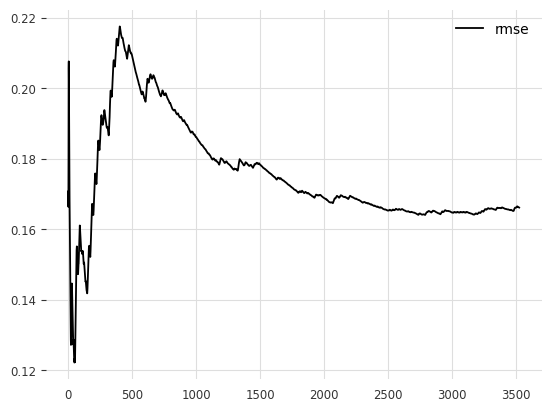


******************************

DATASET.MACKEY_GLASS


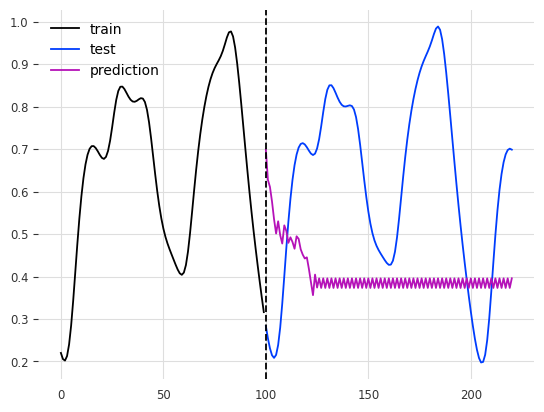

10 steps horizon - rmse = 0.3068
50 steps horizon - rmse = 0.336
100 steps horizon - rmse = 0.3462
121 steps horizon - rmse = 0.3256


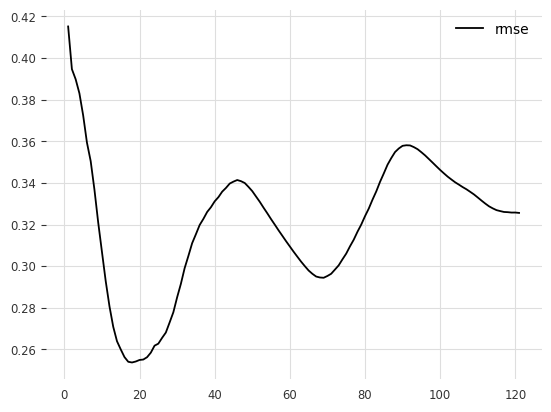


******************************

DATASET.TEMPERATURE


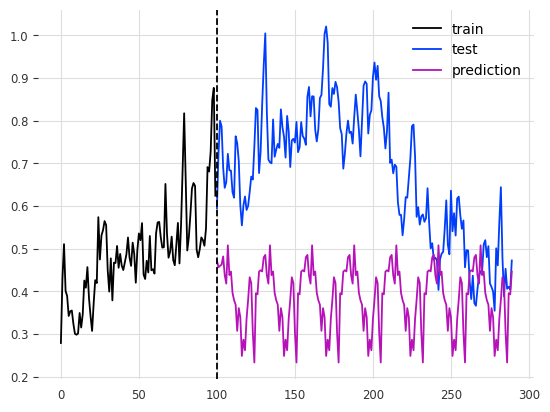

10 steps horizon - rmse = 0.2472
50 steps horizon - rmse = 0.3467
100 steps horizon - rmse = 0.4027
190 steps horizon - rmse = 0.3392


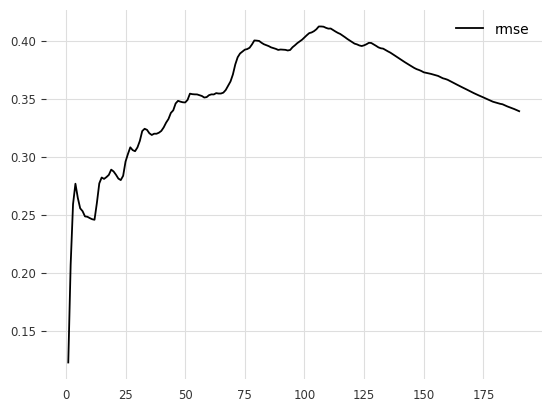


******************************



In [17]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with XGBoost Multi-horizon with future covariates

## Train model

In [18]:
model_name = "xgboost - multihorizon-covariates"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
xgboost_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        },
        "mode": 3
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 month lag": "30 days",
            "15 days lag": "15 days"
        },
        "mode": 3
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = xgboost_params[dataset.name]
    model = predictors.XGBoostPredictor(**params)
    model.fit(df=df_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY
(31707, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.MACKEY_GLASS
(1080, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.TEMPERATURE
(1697, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


## Evaluate model

/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.SUNSPOTS


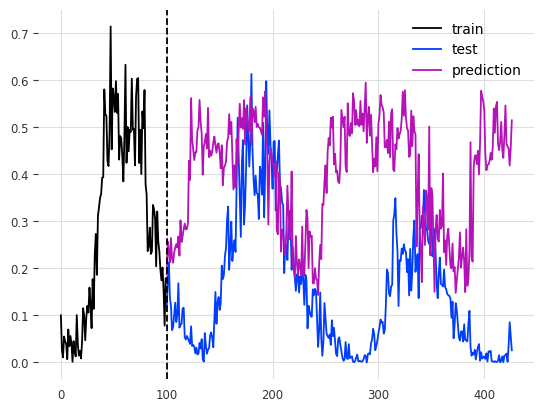

10 steps horizon - rmse = 0.1182
50 steps horizon - rmse = 0.3369
100 steps horizon - rmse = 0.2654
200 steps horizon - rmse = 0.302
300 steps horizon - rmse = 0.2898
327 steps horizon - rmse = 0.3072


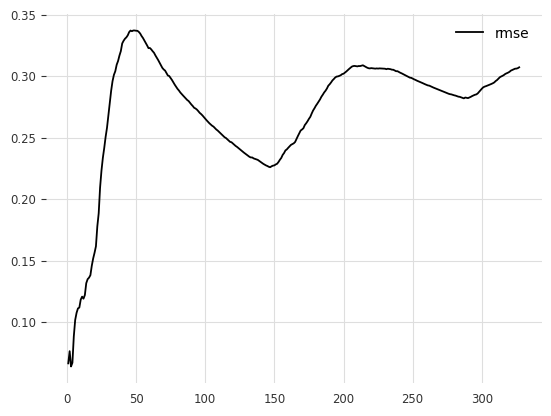


******************************



/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY


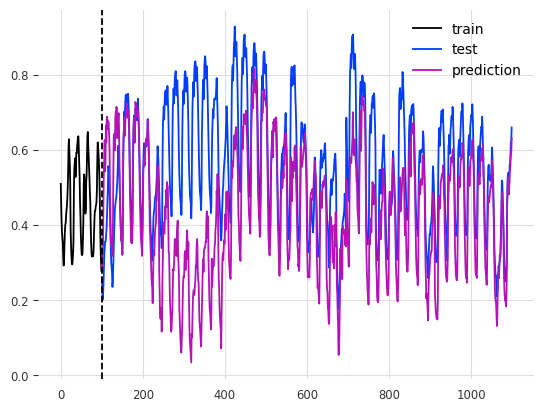

10 steps horizon - rmse = 0.1952
50 steps horizon - rmse = 0.1678
100 steps horizon - rmse = 0.1219
200 steps horizon - rmse = 0.2137
300 steps horizon - rmse = 0.2874
1000 steps horizon - rmse = 0.1888
3524 steps horizon - rmse = 0.156


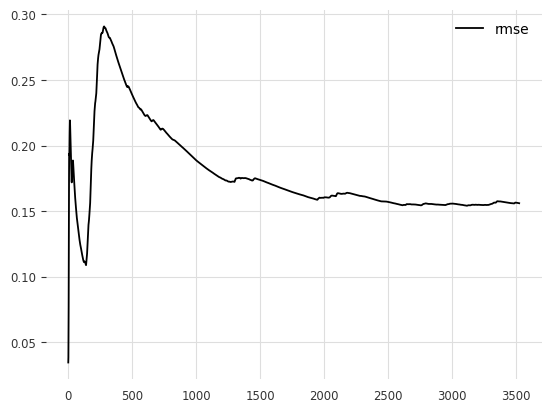


******************************

DATASET.MACKEY_GLASS


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


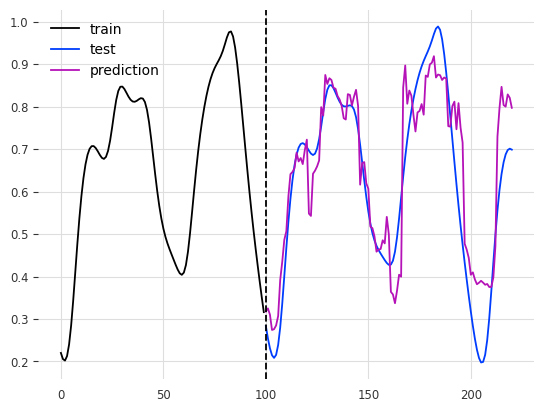

10 steps horizon - rmse = 0.0771
50 steps horizon - rmse = 0.0554
100 steps horizon - rmse = 0.0848
121 steps horizon - rmse = 0.0963


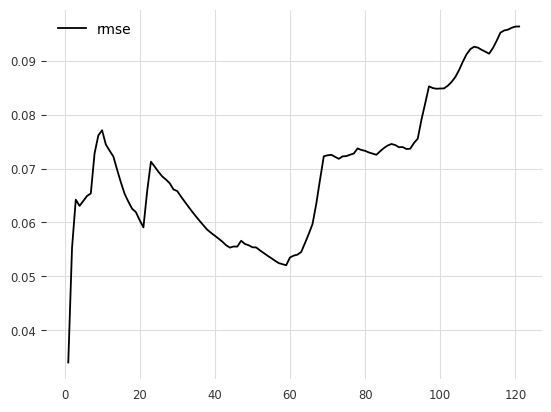


******************************

DATASET.TEMPERATURE


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:314: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


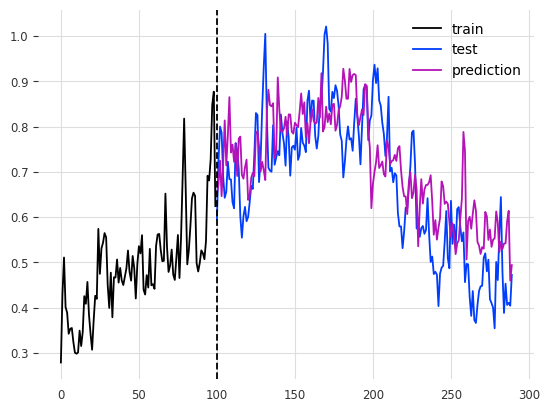

10 steps horizon - rmse = 0.102
50 steps horizon - rmse = 0.1054
100 steps horizon - rmse = 0.1013
190 steps horizon - rmse = 0.1126


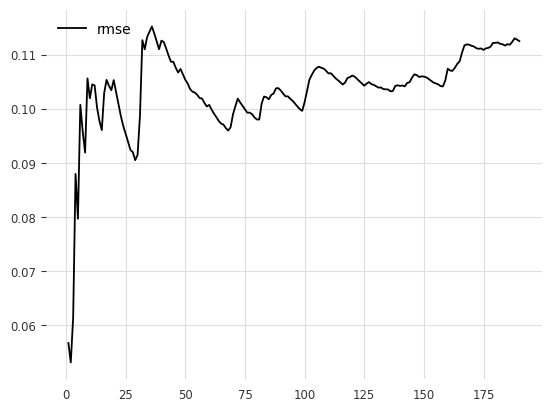


******************************



In [19]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with LightGBM - autoregressive

## Train model

In [20]:
model_name = "lightgbm - ar"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
lightgbm_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": True,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": None,
        "mode": 1
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": None,
        "mode": 1
    }
}

for dataset in datasets:
    print(dataset.name)
    X_train = dataset.X_train
    y_train = dataset.y_train.ravel()
    print(dataset.df_train.shape)
    params = lightgbm_params[dataset.name]
    model = predictors.LightGBMPredictor(**params)
    model.fit(X=X_train, y=y_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)
DATASET.ELECTRICITY
(31706, 2)
DATASET.MACKEY_GLASS
(1080, 2)
DATASET.TEMPERATURE
(1697, 2)


## Evaluate model

DATASET.SUNSPOTS


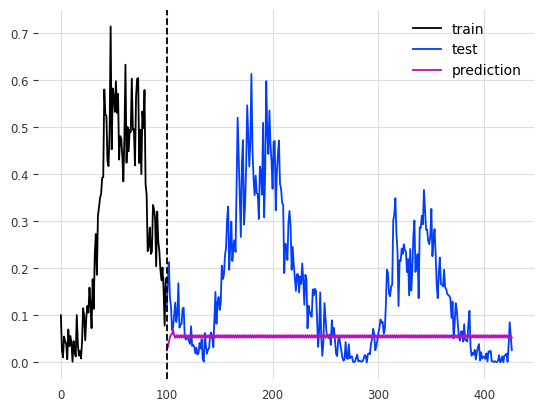

10 steps horizon - rmse = 0.0873
50 steps horizon - rmse = 0.0528
100 steps horizon - rmse = 0.2345
200 steps horizon - rmse = 0.1938
300 steps horizon - rmse = 0.1779
327 steps horizon - rmse = 0.1709


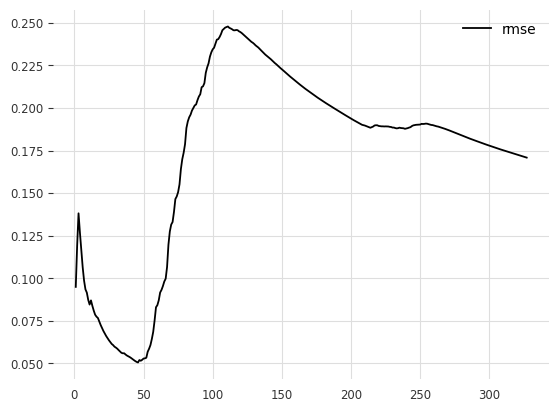


******************************

DATASET.ELECTRICITY


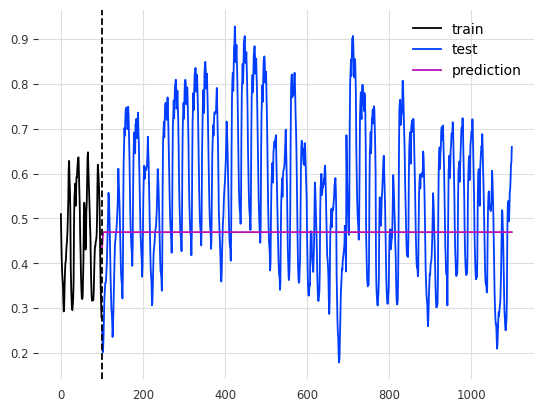

10 steps horizon - rmse = 0.1881
50 steps horizon - rmse = 0.1252
100 steps horizon - rmse = 0.1557
200 steps horizon - rmse = 0.1655
300 steps horizon - rmse = 0.1886
1000 steps horizon - rmse = 0.1853
3524 steps horizon - rmse = 0.1651


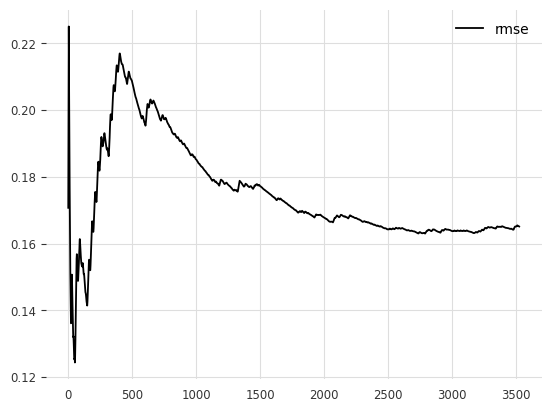


******************************

DATASET.MACKEY_GLASS


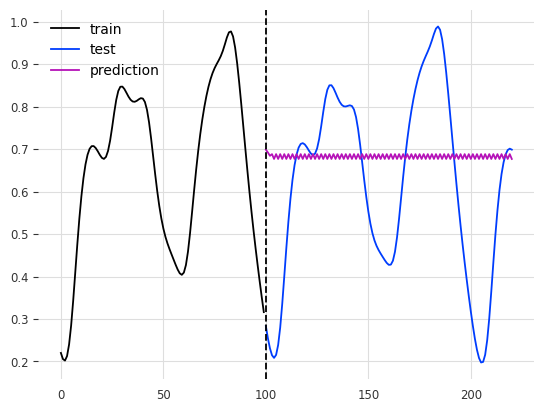

10 steps horizon - rmse = 0.4234
50 steps horizon - rmse = 0.21
100 steps horizon - rmse = 0.2085
121 steps horizon - rmse = 0.2316


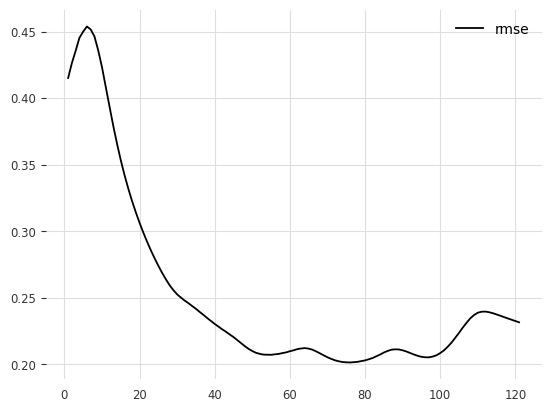


******************************

DATASET.TEMPERATURE


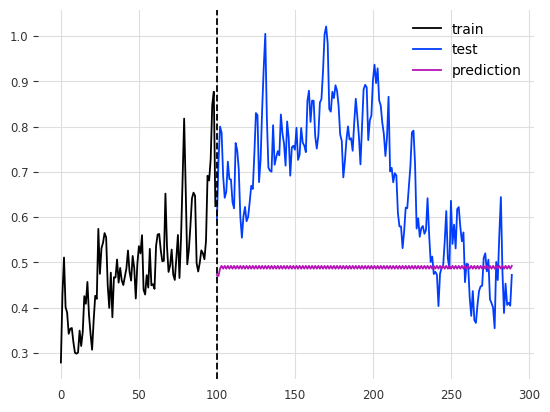

10 steps horizon - rmse = 0.2204
50 steps horizon - rmse = 0.2495
100 steps horizon - rmse = 0.2973
190 steps horizon - rmse = 0.2435


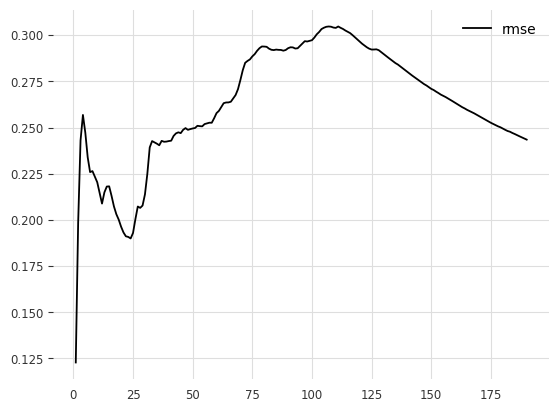


******************************



In [21]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with LightGBM Multi-horizon with future covariates

# Train model

In [22]:
model_name = "lightgbm - multihorizon-covariates"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
lightgbm_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 1000,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        },
        "mode": 3
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        },
        "mode": 3
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 months lag": "30 days",
            "15 days lag": "15 days"
        },
        "mode": 3
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = lightgbm_params[dataset.name]
    model = predictors.LightGBMPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model 

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2938, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY
(31707, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.MACKEY_GLASS
(1080, 2)
DATASET.TEMPERATURE
(1697, 2)


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)
/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


## Evaluate model

/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.SUNSPOTS


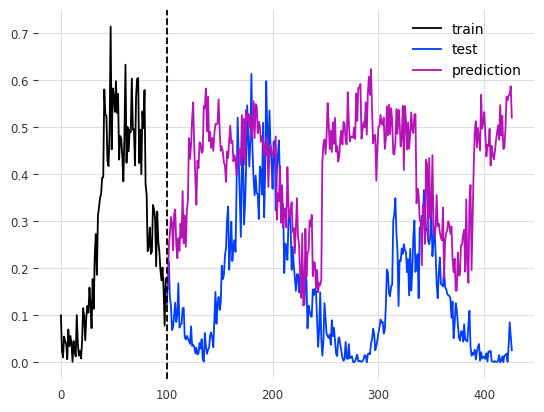

10 steps horizon - rmse = 0.1579
50 steps horizon - rmse = 0.3517
100 steps horizon - rmse = 0.2732
200 steps horizon - rmse = 0.3142
300 steps horizon - rmse = 0.2995
327 steps horizon - rmse = 0.3184


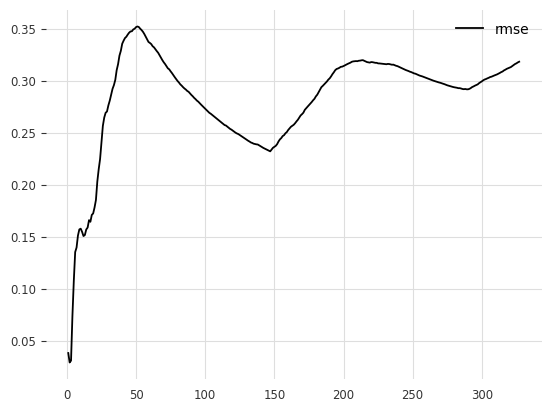


******************************



/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


DATASET.ELECTRICITY


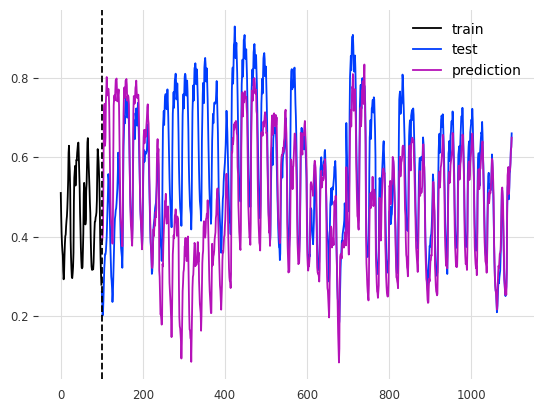

10 steps horizon - rmse = 0.2965
50 steps horizon - rmse = 0.2515
100 steps horizon - rmse = 0.1816
200 steps horizon - rmse = 0.2089
300 steps horizon - rmse = 0.2556
1000 steps horizon - rmse = 0.1574
3524 steps horizon - rmse = 0.1196


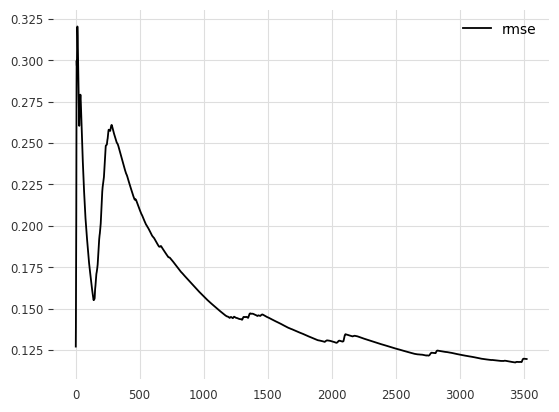


******************************

DATASET.MACKEY_GLASS


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


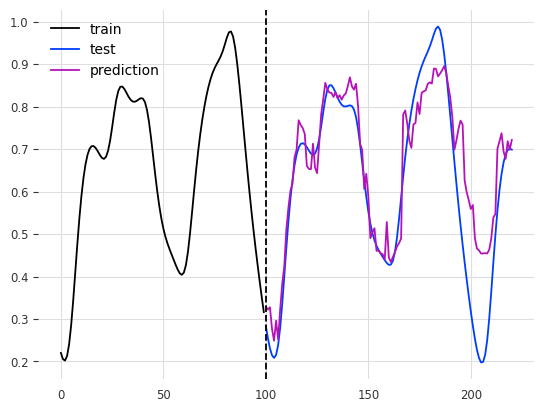

10 steps horizon - rmse = 0.0573
50 steps horizon - rmse = 0.0413
100 steps horizon - rmse = 0.0763
121 steps horizon - rmse = 0.1008


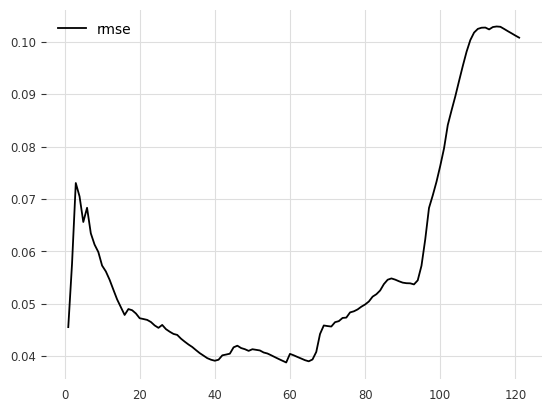


******************************

DATASET.TEMPERATURE


/home/glegeza/Programming/semestr1/time-series-forecasting/utils/predictors.py:427: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  X_extended["weekofyear"] = pd.Int64Index(X.index.isocalendar().week)


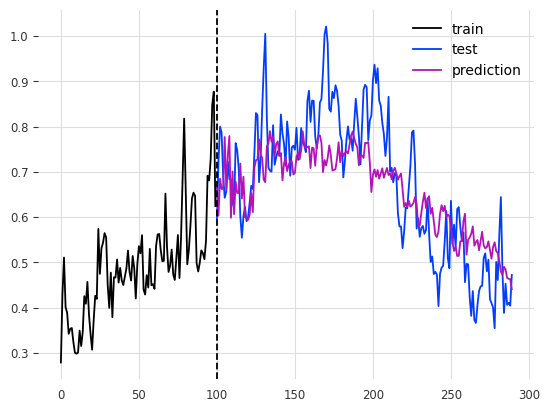

10 steps horizon - rmse = 0.091
50 steps horizon - rmse = 0.0909
100 steps horizon - rmse = 0.1023
190 steps horizon - rmse = 0.1032


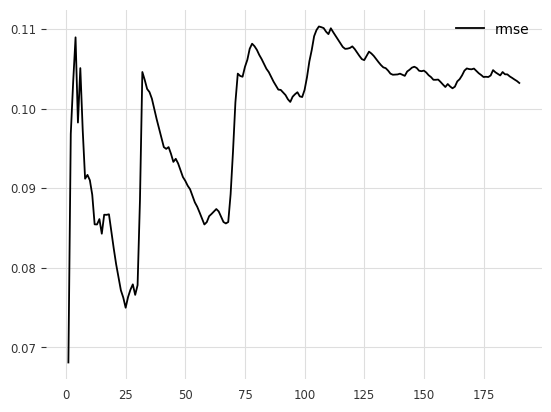


******************************



In [23]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)

    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Forecasting with TFT (multihorizon)

DATASET.SUNSPOTS
/home/glegeza/Programming/semestr1/time-series-forecasting/models/tft/sunspots_i400_h133_21_28_12


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


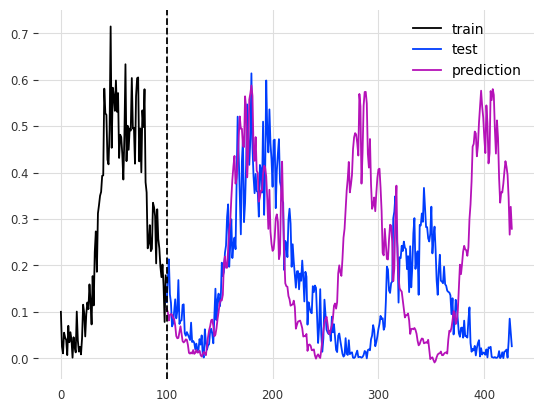

10 steps horizon - rmse = 0.0556
50 steps horizon - rmse = 0.0445
100 steps horizon - rmse = 0.0864
200 steps horizon - rmse = 0.19
300 steps horizon - rmse = 0.2054
327 steps horizon - rmse = 0.2322


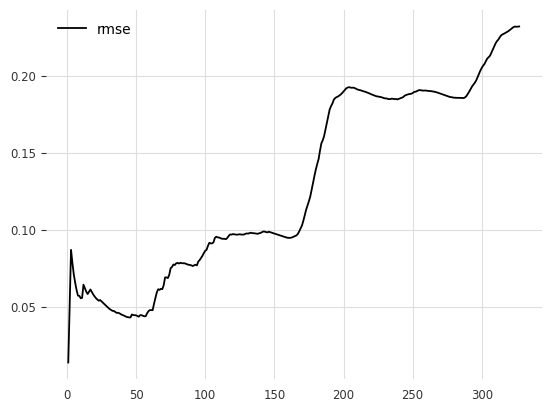


******************************

DATASET.ELECTRICITY
/home/glegeza/Programming/semestr1/time-series-forecasting/models/tft/electricity_i168_h24_21_49_52_best


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [01:23<00:00, 83.37s/it]


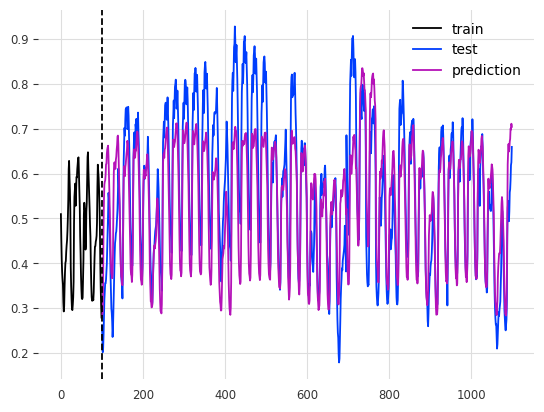

10 steps horizon - rmse = 0.2002
50 steps horizon - rmse = 0.1562
100 steps horizon - rmse = 0.1202
200 steps horizon - rmse = 0.0971
300 steps horizon - rmse = 0.1013
1000 steps horizon - rmse = 0.0951
3524 steps horizon - rmse = 0.1085


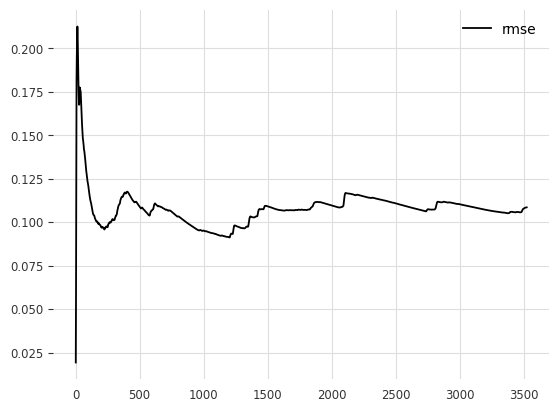


******************************

DATASET.MACKEY_GLASS
/home/glegeza/Programming/semestr1/time-series-forecasting/models/tft/mackey_glass_i100_h50_23_06_54_best


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


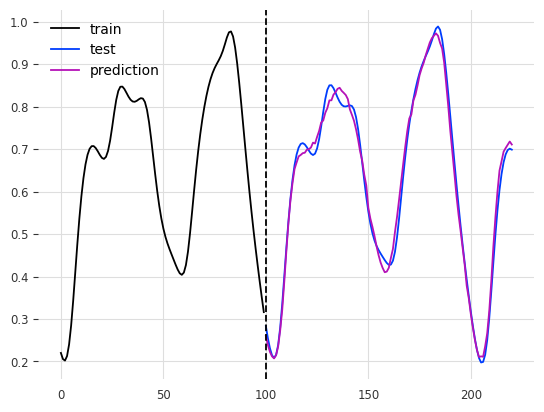

10 steps horizon - rmse = 0.0113
50 steps horizon - rmse = 0.0206
100 steps horizon - rmse = 0.0211
121 steps horizon - rmse = 0.0215


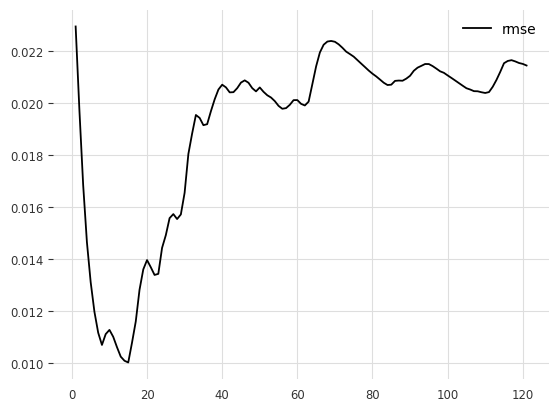


******************************

DATASET.TEMPERATURE
/home/glegeza/Programming/semestr1/time-series-forecasting/models/tft/temperature_i90_h30_23_00_27_best


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/glegeza/Programming/semestr1/time-series-forecasting/venv10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


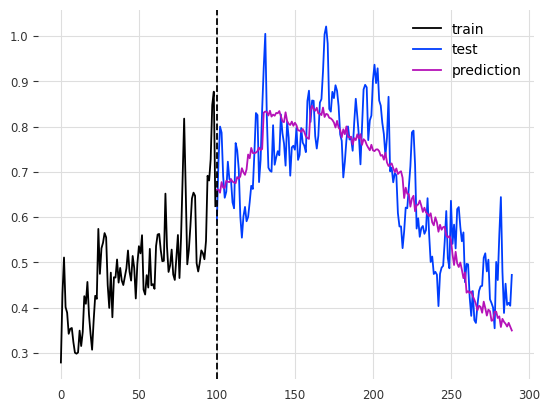

10 steps horizon - rmse = 0.0671
50 steps horizon - rmse = 0.0837
100 steps horizon - rmse = 0.078
190 steps horizon - rmse = 0.0849


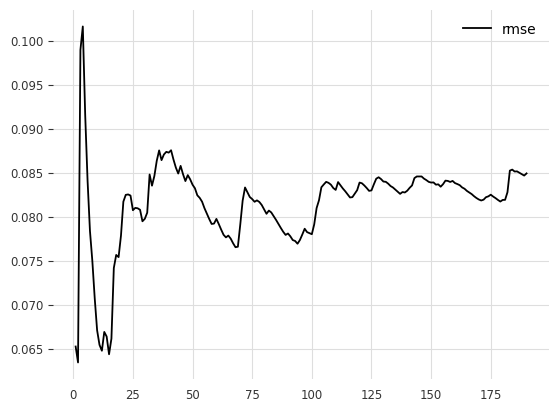


******************************



In [24]:
from collections import defaultdict

model_name = "tft-multihorizon-covariates"
WEIGHTS_DIR = Path().cwd().parent / "models/tft"

EVALUATION_RESULTS[model_name] = defaultdict(dict)

datasets = [sunspots, electricity, mackey_glass, temperature]

for dataset in datasets:
    print(dataset.name)
    model_fname, model_covariates = predictors.get_tft_weights_covariates(dataset.name, multihorizon=True)
    model_path = str(WEIGHTS_DIR / model_fname)
    print(model_path)

    y_pred = predictors.get_tft_predictions(model_path, dataset, model_covariates)
    y_val = dataset.y_val
    y_train = dataset.y_train

    plot_predictions(y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse


# Forecasting with ESN

## Train model

In [25]:
model_name = "esn"
EVALUATION_RESULTS[model_name] = {}

models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
for dataset in datasets:
    print(dataset.name)
    X_train, y_train = dataset.X_train, dataset.y_train
    print(X_train.shape, y_train.shape)
    model = predictors.ESNPredictor(input_size=1, hidden_size=1000, output_size=1, num_layers=4)
    model.fit(X_train, y_train)
    models[dataset.name] = model

    EVALUATION_RESULTS[model_name][dataset.name] = {}
    EVALUATION_RESULTS[model_name][dataset.name]["model"] = model

DATASET.SUNSPOTS
(2937, 1) (2937, 1)
DATASET.ELECTRICITY
(31706, 1) (31706, 1)
DATASET.MACKEY_GLASS
(1079, 1) (1079, 1)
DATASET.TEMPERATURE
(1696, 1) (1696, 1)


## Evaluate model

DATASET.SUNSPOTS


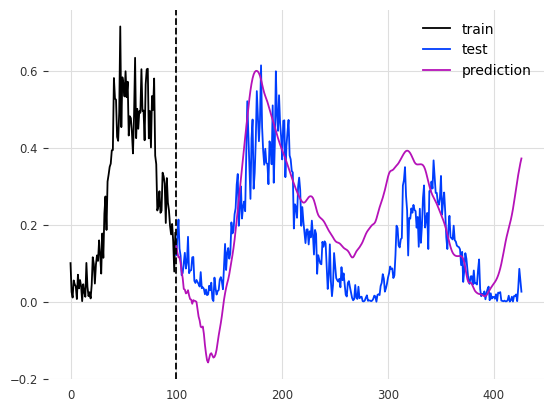

10 steps horizon - rmse = 0.0557
50 steps horizon - rmse = 0.1121
100 steps horizon - rmse = 0.1209
200 steps horizon - rmse = 0.1248
300 steps horizon - rmse = 0.1224
327 steps horizon - rmse = 0.1301


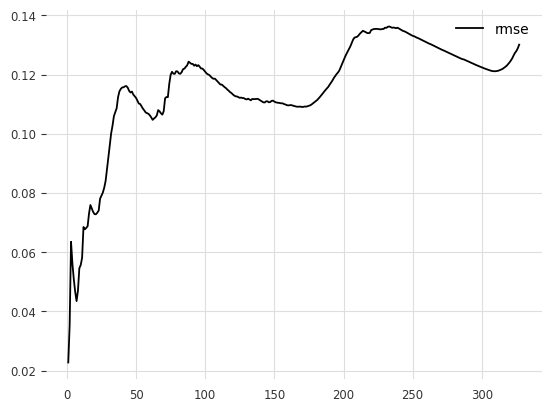


******************************

DATASET.ELECTRICITY


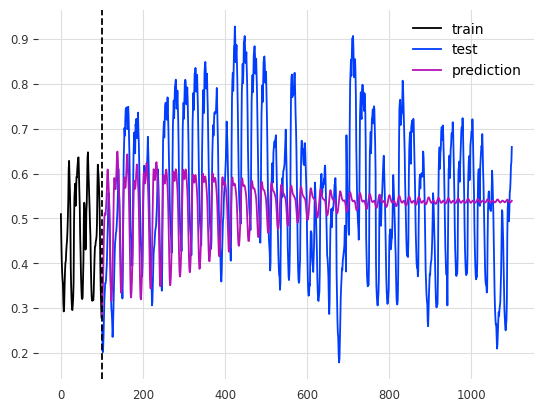

10 steps horizon - rmse = 0.1489
50 steps horizon - rmse = 0.1183
100 steps horizon - rmse = 0.1157
200 steps horizon - rmse = 0.1195
300 steps horizon - rmse = 0.1363
1000 steps horizon - rmse = 0.1536
3524 steps horizon - rmse = 0.158


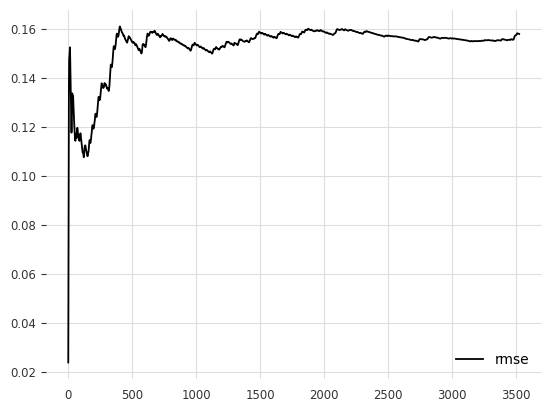


******************************

DATASET.MACKEY_GLASS


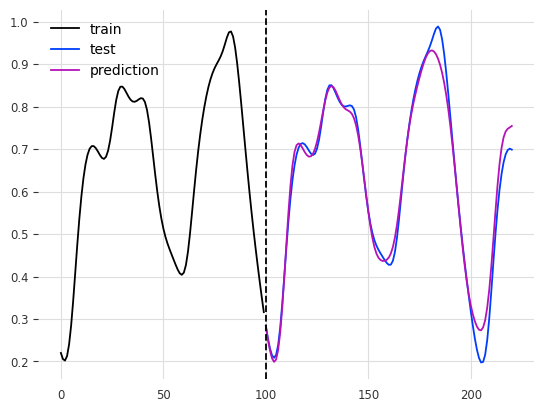

10 steps horizon - rmse = 0.0082
50 steps horizon - rmse = 0.0132
100 steps horizon - rmse = 0.0223
121 steps horizon - rmse = 0.0319


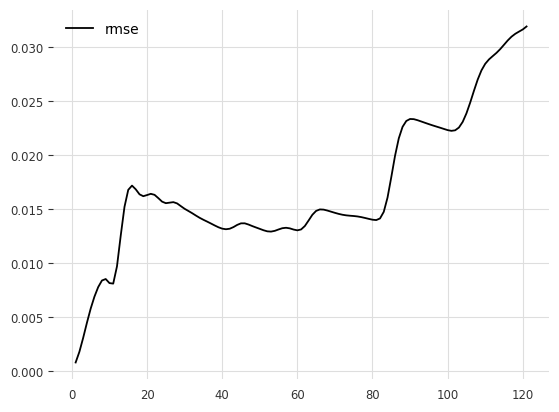


******************************

DATASET.TEMPERATURE


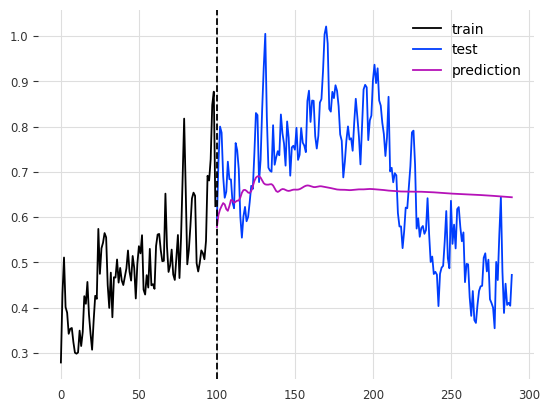

10 steps horizon - rmse = 0.0982
50 steps horizon - rmse = 0.1075
100 steps horizon - rmse = 0.1431
190 steps horizon - rmse = 0.1515


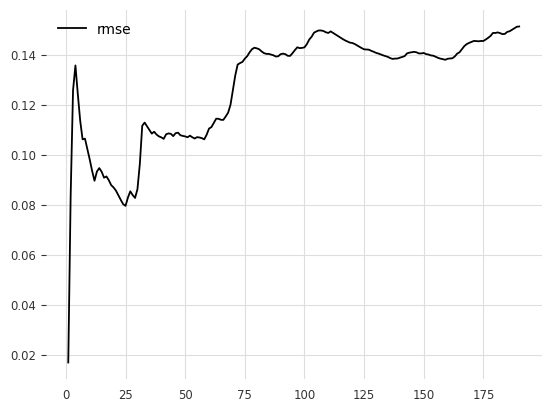


******************************



In [26]:
forecasts = {}
for dataset in datasets:
    y_val = dataset.y_val
    model = models[dataset.name]
    y_pred = model.forecast(y_val.shape[0])
    print(dataset.name)
    
    plot_predictions(dataset.y_train[-MAX_PLOT_TRAIN: ].flatten(), y_val[:MAX_PLOT_HORIZON].flatten(), y_pred[:MAX_PLOT_HORIZON].flatten())
    plt.show()

    rmse = calculate_rmse(y_val.flatten(), y_pred.flatten())
    plt.show()
    print()
    print("*" * 30)
    print()

    EVALUATION_RESULTS[model_name][dataset.name]["prediction"] = y_pred
    EVALUATION_RESULTS[model_name][dataset.name]["rmse"] = rmse

# Evaluation

In [27]:
from darts.metrics import metrics
from darts.timeseries import TimeSeries
from IPython.display import display
from math import ceil

model_names = EVALUATION_RESULTS.keys()
EVALUATION_DF = pd.DataFrame(columns=["dataset name", "model name"])

darts_metrics = {
    "rmse": metrics.rmse,
    "dtw": metrics.dtw_metric,
    "mae": metrics.mae,
    "ope": metrics.ope,
}

In [28]:
def make_evaluation(dataset):
    eval_df = pd.DataFrame()
    dataset_name = dataset.name

    y_train = dataset.y_train[-MAX_PLOT_TRAIN: ].flatten()
    y_test = dataset.y_val[:MAX_PLOT_HORIZON].flatten()
    xrange_train = np.arange(y_train.shape[0])
    xrange_test = np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0])

    fig, axs = plt.subplots(ceil(len(model_names) / 2), 2, figsize=(15, 15))
    for num, model_name in enumerate(model_names):
        i = num // 2
        j = num % 2

        sns.lineplot(y=y_train, x=xrange_train, label="train", ax=axs[i, j])
        sns.lineplot(y=y_test, x=xrange_test, label="test", ax=axs[i, j])
        y_pred = EVALUATION_RESULTS[model_name][dataset_name]["prediction"].flatten()
        sns.lineplot(y=y_pred[:MAX_PLOT_HORIZON], x=xrange_test, label=model_name, ax=axs[i, j], color="green")
        axs[i, j].axvline(x=y_train.shape[0], linestyle="--", color="black")
        axs[i, j].set_title(f"model: {model_name}")
    plt.show()


    plt.figure(figsize=(7, 7))
    plt.title("RMSE")
    for model_name in model_names:
        rmse = EVALUATION_RESULTS[model_name][dataset_name]["rmse"][:MAX_PLOT_HORIZON]
        predicted_days = np.arange(1, rmse.shape[0]+1)
        sns.lineplot(y=rmse, x=predicted_days, label=model_name)
    plt.show()

    plt.figure(figsize=(7, 7))
    plt.title("RMSE - 50 steps")
    for model_name in model_names:
        rmse = EVALUATION_RESULTS[model_name][dataset_name]["rmse"][:50]
        predicted_days = np.arange(1, rmse.shape[0]+1)
        sns.lineplot(y=rmse, x=predicted_days, label=model_name)
    plt.show()

    HORIZONS = [1, 10, 20, 50, 100, 250]

    for model_name in model_names:
        rmse = EVALUATION_RESULTS[model_name][dataset_name]["rmse"]
        row = {"dataset name": [dataset_name.value], "model name": [model_name]}
        for h in HORIZONS:
            if h > rmse.shape[0]:
                row[f"rmse - {h}"] = [None]
                continue
            row[f"rmse - {h}"] = [rmse[h - 1]]

        y_pred = EVALUATION_RESULTS[model_name][dataset_name]["prediction"].flatten()
        pred = TimeSeries.from_values(y_pred)
        test = TimeSeries.from_values(y_test)

        for label, metric in darts_metrics.items():
            row[label] = [metric(test, pred)]

        eval_df = pd.concat([eval_df, pd.DataFrame(row)], ignore_index=True)

    darts_metrics_df = eval_df.loc[eval_df["dataset name"] == dataset_name][["model name"] + list(darts_metrics.keys())].copy()
    darts_metrics_df = darts_metrics_df.set_index("model name")
    darts_metrics_df = darts_metrics_df / darts_metrics_df.max(axis=0)
    darts_metrics_df = darts_metrics_df.stack().to_frame().reset_index()
    darts_metrics_df.columns = ["model", "metric", "normalized value"]

    plt.figure(figsize=(7, 7))
    sns.lineplot(data=darts_metrics_df, x="metric", y="normalized value", hue="model", marker="o")
    plt.show()

    display(eval_df.loc[eval_df["dataset name"] == dataset_name])

    return eval_df

## Mackey Glass

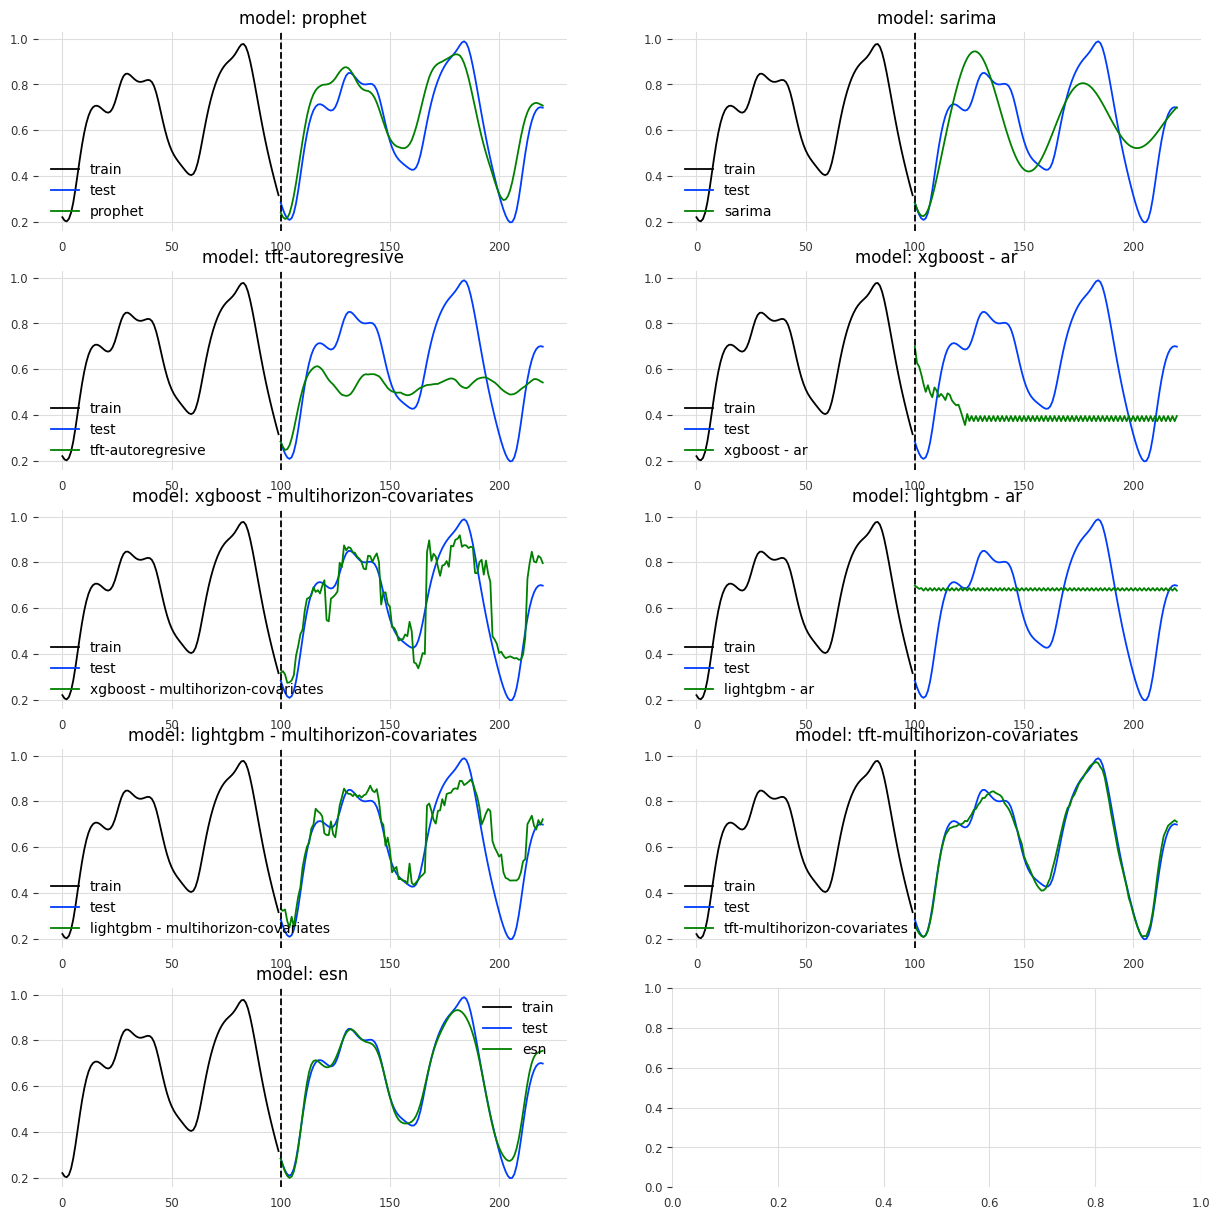

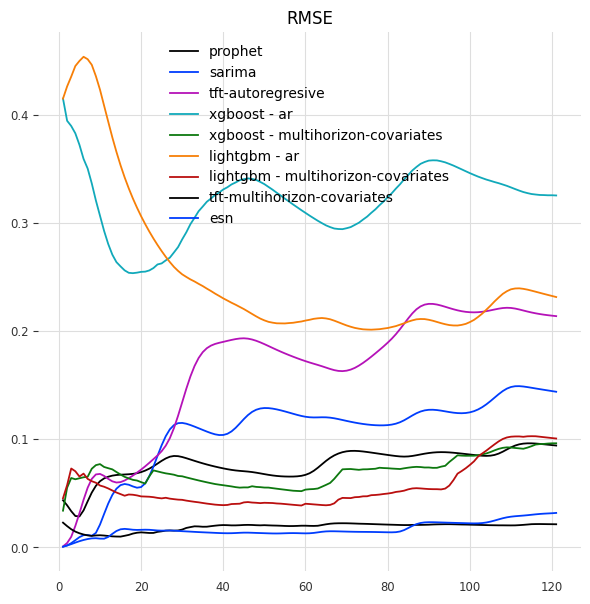

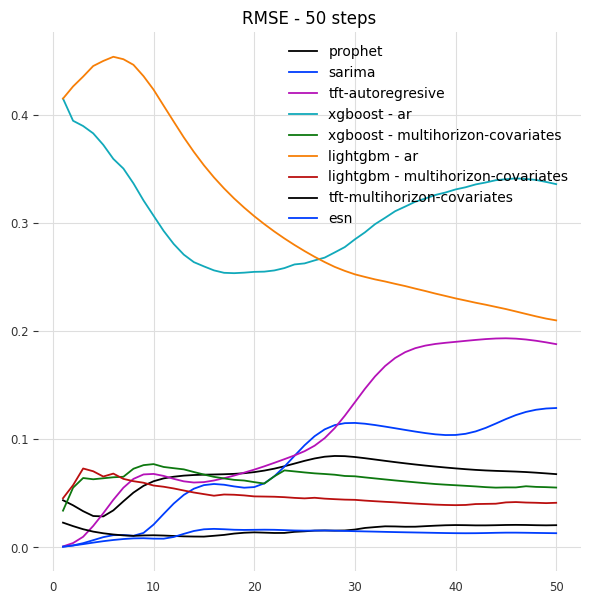

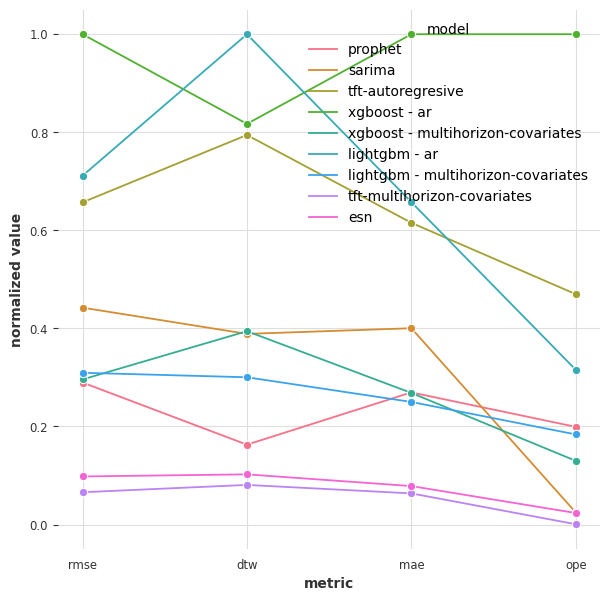

dataset name                          model name  rmse - 1  rmse - 10  \
0  mackey_glass                             prophet  0.043672   0.061253   
1  mackey_glass                              sarima  0.000632   0.021161   
2  mackey_glass                   tft-autoregresive  0.000944   0.068021   
3  mackey_glass                        xgboost - ar  0.415169   0.306818   
4  mackey_glass   xgboost - multihorizon-covariates  0.034045   0.077102   
5  mackey_glass                       lightgbm - ar  0.415169   0.423407   
6  mackey_glass  lightgbm - multihorizon-covariates  0.045543   0.057285   
7  mackey_glass         tft-multihorizon-covariates  0.022956   0.011288   
8  mackey_glass                                 esn  0.000812   0.008165   

   rmse - 20  rmse - 50  rmse - 100 rmse - 250      rmse       dtw       mae  \
0   0.069693   0.067827    0.085976       None  0.094283  0.018827  0.076031   
1   0.055848   0.128969    0.124982       None  0.144024  0.044945  0.112940   
2   0.072001   0.188065    0.217573       None  0.213963  0.091827  0.173587   
3   0.254912   0.336048    0.346226       None  0.325579  0.094450  0.282091   
4   0.060430   0.055410    0.084846       None  0.096346  0.045578  0.075709   
5   0.306403   0.210038    0.208457       None  0.231634  0.115583  0.185493   
6   0.047238   0.041321    0.076327       None  0.100777  0.034718  0.070534   
7   0.013973   0.020611    0.021074       None  0.021456  0.009341  0.017920   
8   0.016318   0.013190    0.022336       None  0.031935  0.011828  0.022133   

         ope  
0   6.769927  
1   0.838516  
2  15.965019  
3  33.978717  
4   4.415606  
5  10.725303  
6   6.243940  
7   0.022012  
8   0.798186

In [29]:
res_df = make_evaluation(mackey_glass)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

# Sunspots

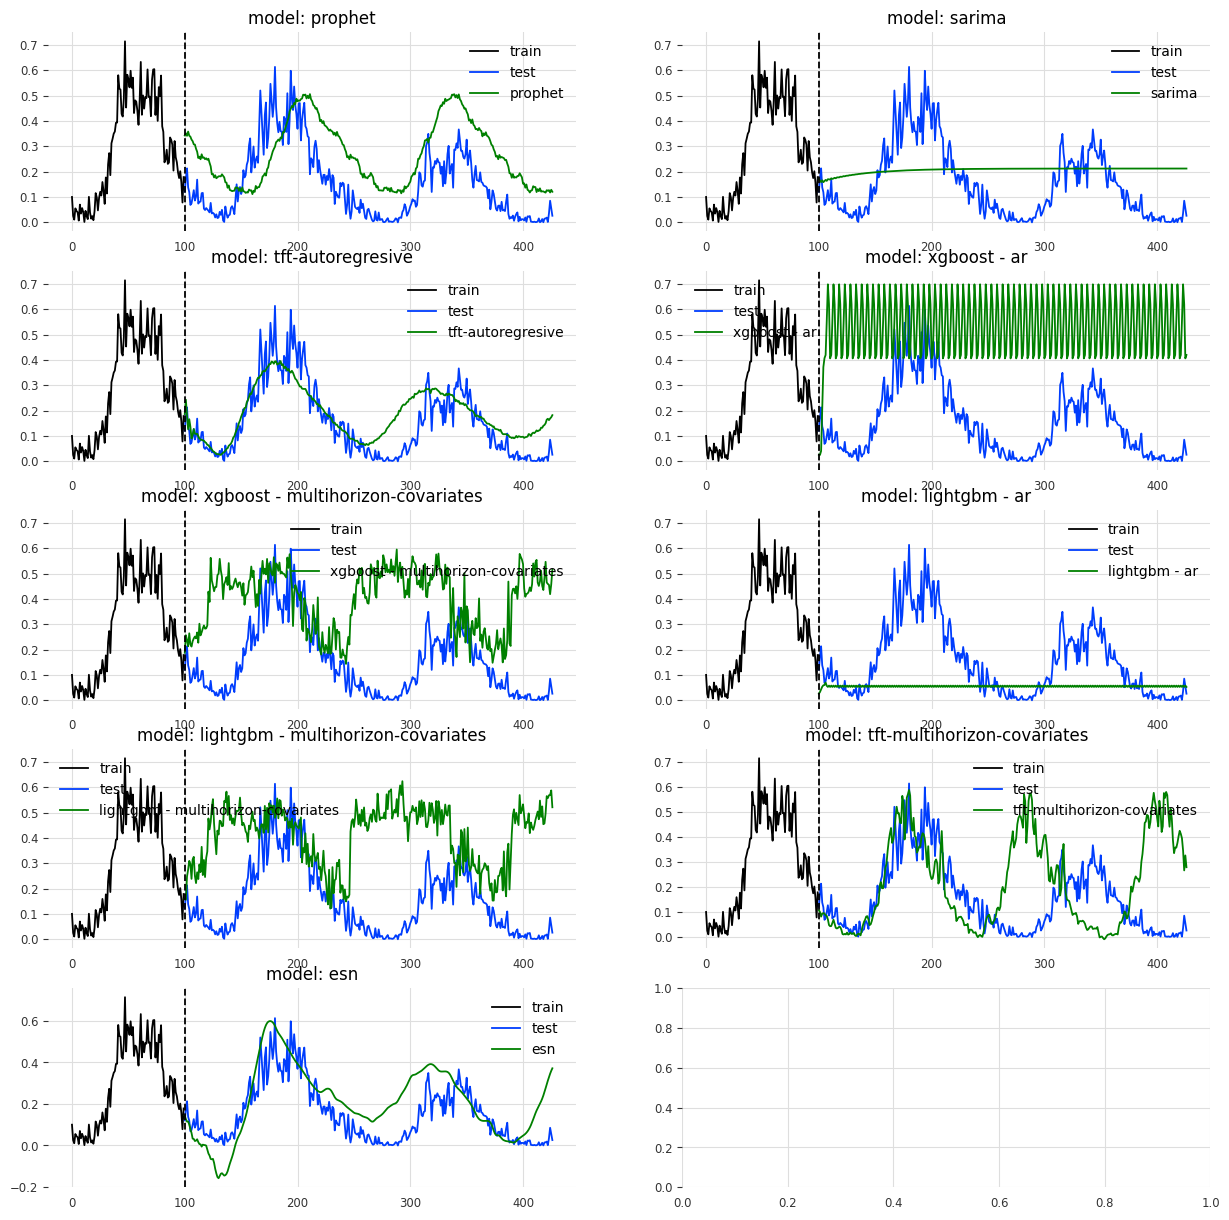

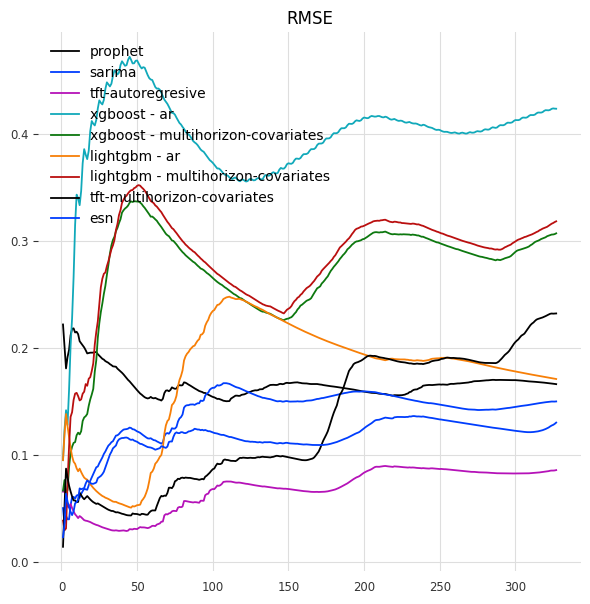

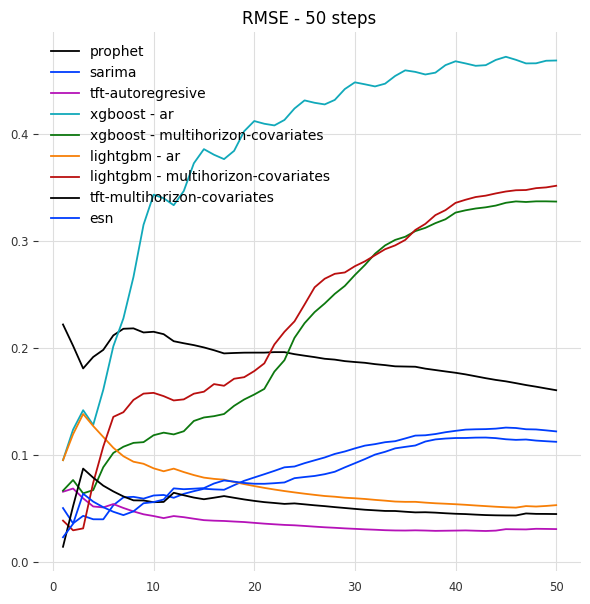

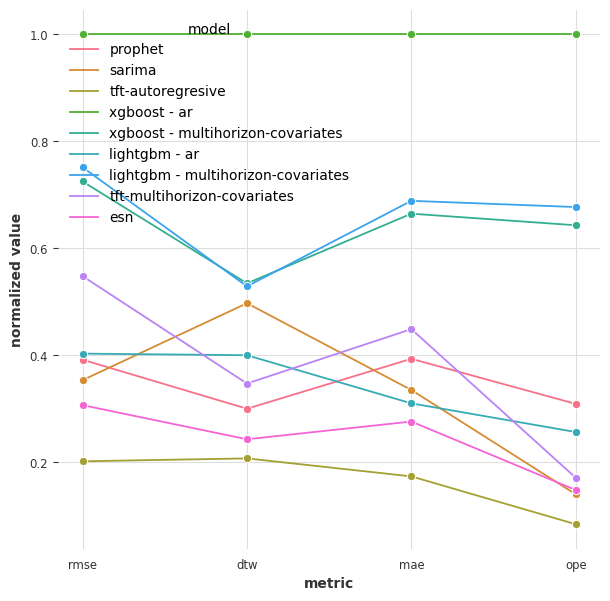

dataset name                          model name  rmse - 1  rmse - 10  \
0     sunspots                             prophet  0.221891   0.215070   
1     sunspots                              sarima  0.050093   0.061861   
2     sunspots                   tft-autoregresive  0.065380   0.042636   
3     sunspots                        xgboost - ar  0.094927   0.343372   
4     sunspots   xgboost - multihorizon-covariates  0.066413   0.118244   
5     sunspots                       lightgbm - ar  0.094927   0.087297   
6     sunspots  lightgbm - multihorizon-covariates  0.038350   0.157907   
7     sunspots         tft-multihorizon-covariates  0.013868   0.055576   
8     sunspots                                 esn  0.022782   0.055679   

   rmse - 20  rmse - 50  rmse - 100  rmse - 250      rmse       dtw       mae  \
0   0.195557   0.160377    0.154099    0.165781  0.166066  0.047698  0.152124   
1   0.078714   0.121844    0.162654    0.146871  0.149876  0.079017  0.129588   
2   0.036261   0.030428    0.067908    0.086635  0.085617  0.032955  0.067194   
3   0.412273   0.468927    0.373150    0.403928  0.423792  0.158868  0.386566   
4   0.156345   0.336914    0.265367    0.298002  0.307187  0.084906  0.256955   
5   0.070691   0.052815    0.234493    0.190303  0.170879  0.063580  0.119951   
6   0.178271   0.351697    0.273170    0.307816  0.318431  0.084030  0.266231   
7   0.056813   0.044505    0.086436    0.188916  0.232213  0.055178  0.173552   
8   0.072860   0.112106    0.120939    0.133048  0.130079  0.038634  0.106814   

          ope  
0   76.878841  
1   34.887256  
2   20.992504  
3  248.597807  
4  159.865445  
5   63.815624  
6  168.319770  
7   42.570272  
8   36.874594

In [30]:
res_df = make_evaluation(sunspots)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

# Electricity

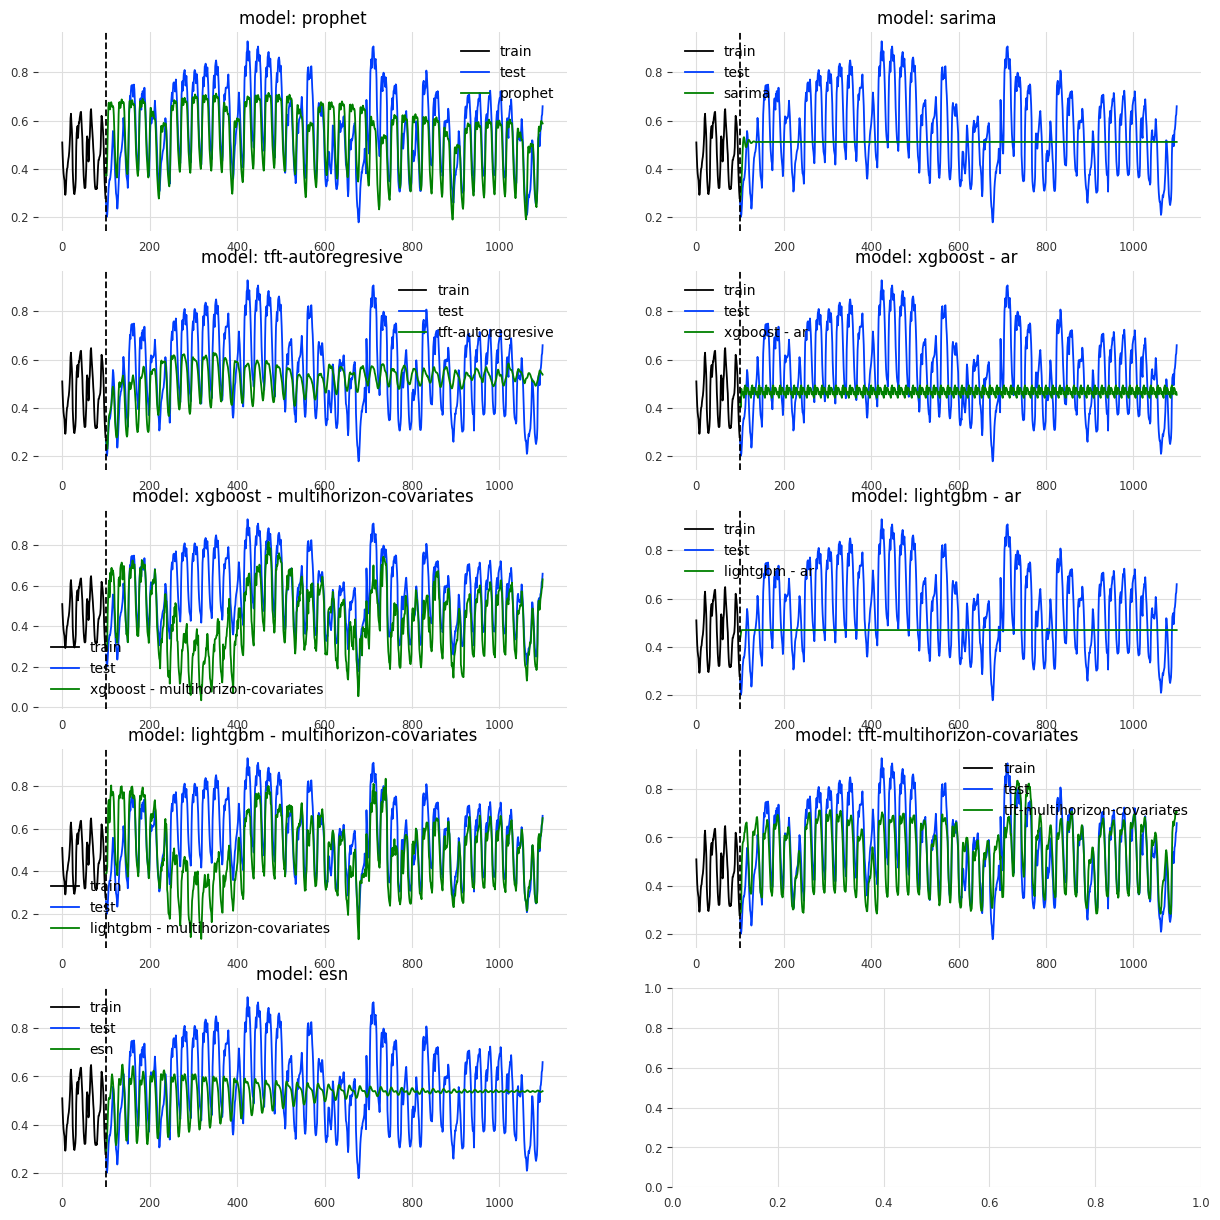

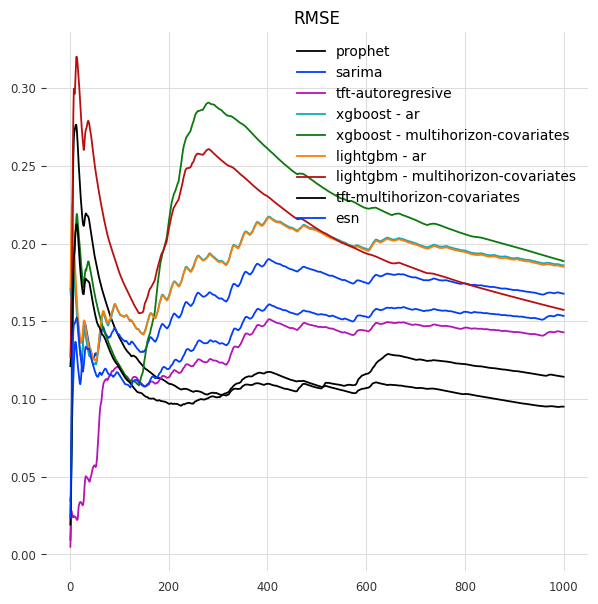

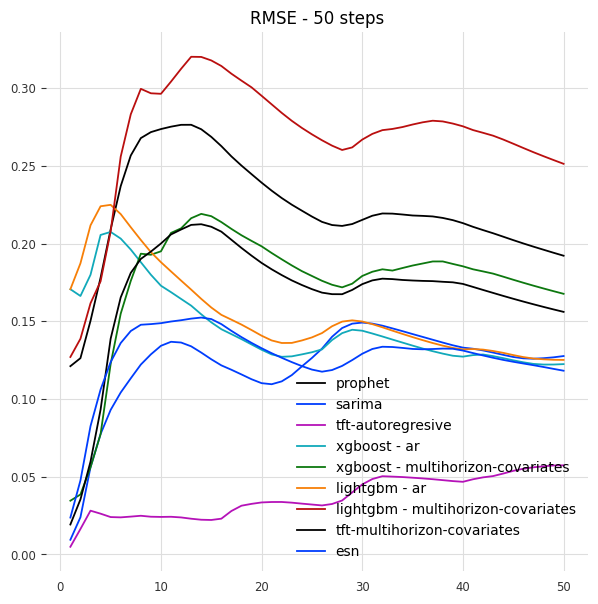

Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.
Exact evaluation will result in poor performance on large datasets. Cons

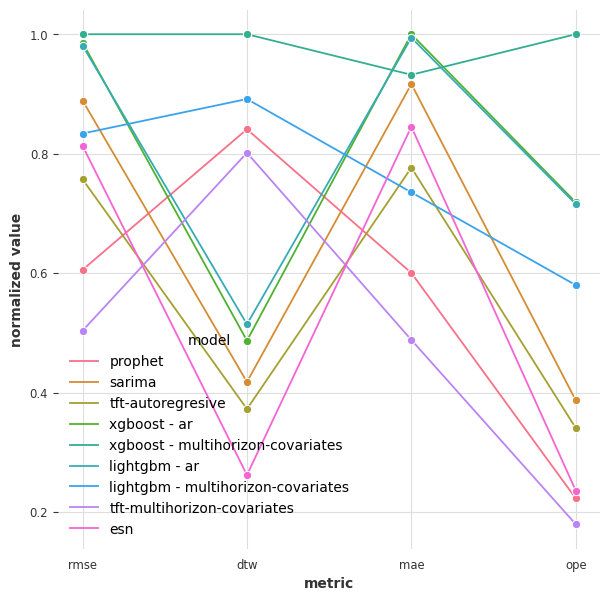

dataset name                          model name  rmse - 1  rmse - 10  \
0  electricity                             prophet  0.121207   0.273848   
1  electricity                              sarima  0.009447   0.134328   
2  electricity                   tft-autoregresive  0.004936   0.024153   
3  electricity                        xgboost - ar  0.170737   0.172982   
4  electricity   xgboost - multihorizon-covariates  0.034597   0.195151   
5  electricity                       lightgbm - ar  0.170737   0.188124   
6  electricity  lightgbm - multihorizon-covariates  0.127113   0.296542   
7  electricity         tft-multihorizon-covariates  0.019273   0.200180   
8  electricity                                 esn  0.023749   0.148885   

   rmse - 20  rmse - 50  rmse - 100  rmse - 250      rmse       dtw       mae  \
0   0.239340   0.192315    0.139738    0.104660  0.114383  0.069696  0.091642   
1   0.110261   0.127719    0.141524    0.161821  0.167880  0.034646  0.139889   
2   0.033485   0.057359    0.119788    0.121347  0.142988  0.030892  0.118529   
3   0.131766   0.122524    0.155332    0.185293  0.186174  0.040372  0.152615   
4   0.198350   0.167786    0.121923    0.278381  0.188839  0.082876  0.142253   
5   0.140821   0.125233    0.155657    0.184224  0.185251  0.042645  0.151735   
6   0.295259   0.251474    0.181559    0.252547  0.157449  0.073887  0.112226   
7   0.187656   0.156160    0.120218    0.097099  0.095139  0.066433  0.074536   
8   0.132746   0.118285    0.115701    0.131542  0.153575  0.021734  0.128986   

         ope  
0   5.000596  
1   8.678428  
2   7.640217  
3  16.102086  
4  22.406877  
5  16.037969  
6  12.998483  
7   4.031174  
8   5.293033

In [31]:
res_df = make_evaluation(electricity)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

# Temperature

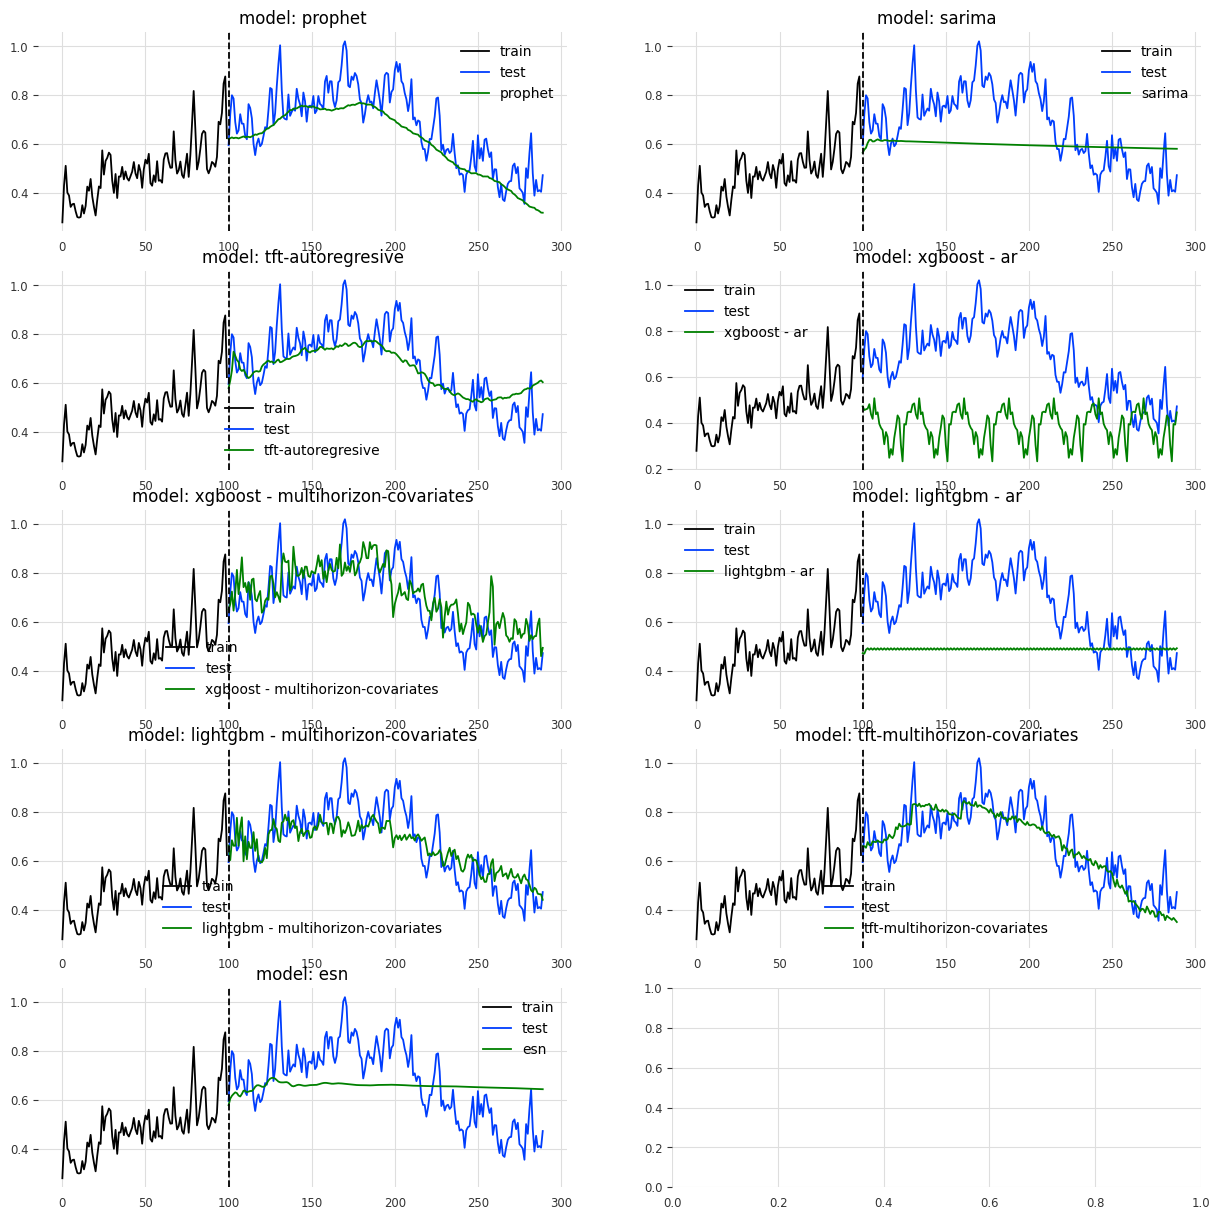

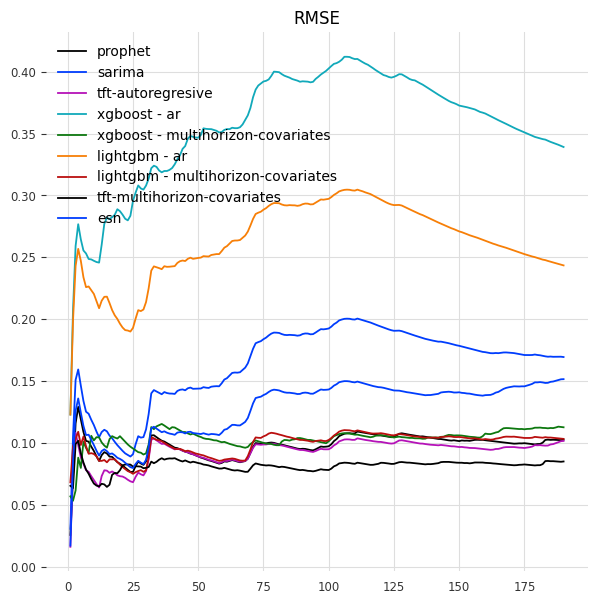

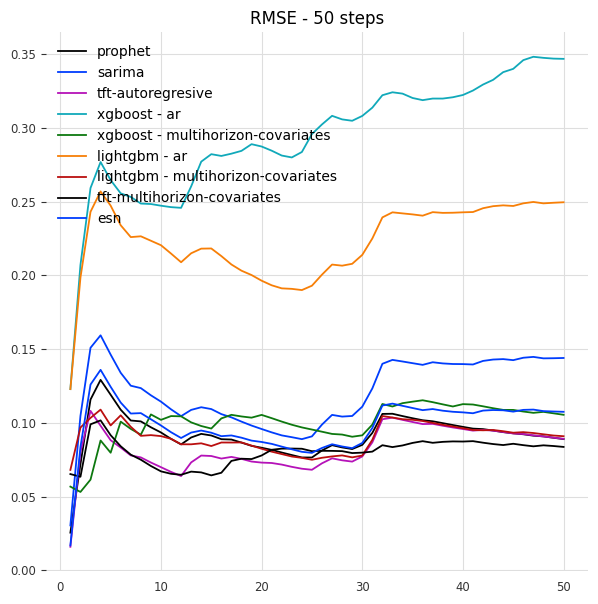

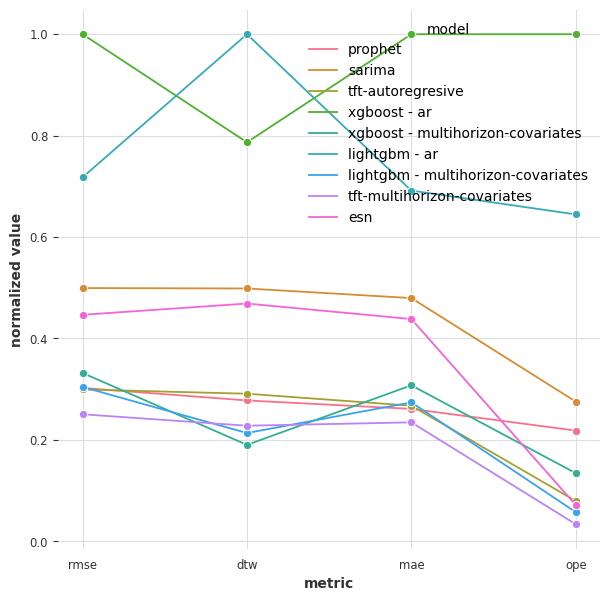

dataset name                          model name  rmse - 1  rmse - 10  \
0  temperature                             prophet  0.025550   0.093455   
1  temperature                              sarima  0.030483   0.114358   
2  temperature                   tft-autoregresive  0.015979   0.069936   
3  temperature                        xgboost - ar  0.122843   0.247160   
4  temperature   xgboost - multihorizon-covariates  0.056749   0.102009   
5  temperature                       lightgbm - ar  0.122843   0.220383   
6  temperature  lightgbm - multihorizon-covariates  0.068091   0.090985   
7  temperature         tft-multihorizon-covariates  0.065260   0.067104   
8  temperature                                 esn  0.016927   0.098193   

   rmse - 20  rmse - 50  rmse - 100 rmse - 250      rmse       dtw       mae  \
0   0.083101   0.088971    0.097221       None  0.102551  0.044899  0.077521   
1   0.095799   0.143949    0.192450       None  0.169374  0.080602  0.142422   
2   0.073039   0.089129    0.094806       None  0.101540  0.047045  0.079379   
3   0.287283   0.346697    0.402671       None  0.339178  0.127217  0.296956   
4   0.105369   0.105440    0.101266       None  0.112583  0.030734  0.091326   
5   0.196333   0.249497    0.297269       None  0.243464  0.161679  0.205371   
6   0.082429   0.090912    0.102338       None  0.103206  0.034509  0.081343   
7   0.077866   0.083660    0.078030       None  0.084943  0.036843  0.069637   
8   0.087017   0.107466    0.143126       None  0.151492  0.075799  0.130131   

         ope  
0   9.388515  
1  11.845481  
2   3.419439  
3  43.017595  
4   5.777015  
5  27.728574  
6   2.467824  
7   1.445383  
8   3.072369

In [32]:
res_df = make_evaluation(temperature)
EVALUATION_DF = pd.concat([EVALUATION_DF, res_df], ignore_index=True)

In [33]:
EVALUATION_DF

dataset name                          model name  rmse - 1  rmse - 10  \
0   mackey_glass                             prophet  0.043672   0.061253   
1   mackey_glass                              sarima  0.000632   0.021161   
2   mackey_glass                   tft-autoregresive  0.000944   0.068021   
3   mackey_glass                        xgboost - ar  0.415169   0.306818   
4   mackey_glass   xgboost - multihorizon-covariates  0.034045   0.077102   
5   mackey_glass                       lightgbm - ar  0.415169   0.423407   
6   mackey_glass  lightgbm - multihorizon-covariates  0.045543   0.057285   
7   mackey_glass         tft-multihorizon-covariates  0.022956   0.011288   
8   mackey_glass                                 esn  0.000812   0.008165   
9       sunspots                             prophet  0.221891   0.215070   
10      sunspots                              sarima  0.050093   0.061861   
11      sunspots                   tft-autoregresive  0.065380   0.042636   
12      sunspots                        xgboost - ar  0.094927   0.343372   
13      sunspots   xgboost - multihorizon-covariates  0.066413   0.118244   
14      sunspots                       lightgbm - ar  0.094927   0.087297   
15      sunspots  lightgbm - multihorizon-covariates  0.038350   0.157907   
16      sunspots         tft-multihorizon-covariates  0.013868   0.055576   
17      sunspots                                 esn  0.022782   0.055679   
18   electricity                             prophet  0.121207   0.273848   
19   electricity                              sarima  0.009447   0.134328   
20   electricity                   tft-autoregresive  0.004936   0.024153   
21   electricity                        xgboost - ar  0.170737   0.172982   
22   electricity   xgboost - multihorizon-covariates  0.034597   0.195151   
23   electricity                       lightgbm - ar  0.170737   0.188124   
24   electricity  lightgbm - multihorizon-covariates  0.127113   0.296542   
25   electricity         tft-multihorizon-covariates  0.019273   0.200180   
26   electricity                                 esn  0.023749   0.148885   
27   temperature                             prophet  0.025550   0.093455   
28   temperature                              sarima  0.030483   0.114358   
29   temperature                   tft-autoregresive  0.015979   0.069936   
30   temperature                        xgboost - ar  0.122843   0.247160   
31   temperature   xgboost - multihorizon-covariates  0.056749   0.102009   
32   temperature                       lightgbm - ar  0.122843   0.220383   
33   temperature  lightgbm - multihorizon-covariates  0.068091   0.090985   
34   temperature         tft-multihorizon-covariates  0.065260   0.067104   
35   temperature                                 esn  0.016927   0.098193   

    rmse - 20  rmse - 50  rmse - 100 rmse - 250      rmse       dtw       mae  \
0    0.069693   0.067827    0.085976        NaN  0.094283  0.018827  0.076031   
1    0.055848   0.128969    0.124982        NaN  0.144024  0.044945  0.112940   
2    0.072001   0.188065    0.217573        NaN  0.213963  0.091827  0.173587   
3    0.254912   0.336048    0.346226        NaN  0.325579  0.094450  0.282091   
4    0.060430   0.055410    0.084846        NaN  0.096346  0.045578  0.075709   
5    0.306403   0.210038    0.208457        NaN  0.231634  0.115583  0.185493   
6    0.047238   0.041321    0.076327        NaN  0.100777  0.034718  0.070534   
7    0.013973   0.020611    0.021074        NaN  0.021456  0.009341  0.017920   
8    0.016318   0.013190    0.022336        NaN  0.031935  0.011828  0.022133   
9    0.195557   0.160377    0.154099   0.165781  0.166066  0.047698  0.152124   
10   0.078714   0.121844    0.162654   0.146871  0.149876  0.079017  0.129588   
11   0.036261   0.030428    0.067908   0.086635  0.085617  0.032955  0.067194   
12   0.412273   0.468927    0.373150   0.403928  0.423792  0.158868  0.386566   
13   0.156345   0.33